In [321]:
# git clone https://github.com/BlackkkMaster/ad_project_team16
# %cd ad_project_team16

# Анализ спроса на самокаты

Для повышения прибыльности проекта руководство компании хочет внедрить динамическую систему определения стоимости поездки.

В данной тетрадке проводится анализ имеющихся данных и поиск определяющих объем спроса факторов, на которые необходимо обратить внимание при формировании такой системы.

Исследование состоит из следующих шагов:

- Предобработка данных (EDA)
- Расчётные задачи
- Проверка гипотез
- Построение регрессионной модели

## Содзадние и настрйока нужных функций и импортов

### Импорты

In [322]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import datetime as dt

### Функции

In [323]:
def pass_value_barh(df, df_tittle):
    try:
        (
            (df.isna().mean() * 100)
            .to_frame()
            .rename(columns={0: "space"})
            .query("space > 0")
            .sort_values(by="space", ascending=True)
            .plot(kind="barh", figsize=(10, 5), rot=0, legend=False, fontsize=12)
            .set_title(
                f'Доля пропусков в столбцах датафрейма "{df_tittle}" (%)' + "\n",
                fontsize=16,
                color="SteelBlue",
            )
        )
    except:
        print("Пропусков нет")


def streets_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"ул\.?\s?", value="")
    return tdf


def rayons_format(tdf, column):
    tdf[column] = tdf[column].str.lower()
    tdf[column] = tdf[column].replace(regex=r"\s", value="-")
    return tdf

# Функция для проверки на нормальность:
def test_stapiro(_df, _column, _pv=0.05):

    _stat, _p_value = st.shapiro(_df[_column])

    print(f"shapiro-Wilk Test Statistic для '{_column}': {_stat:.4f}")
    print(f"shapiro-Wilk P-value для '{_column}': {_p_value:.4f}")
    print(
        f"Расспределение '{_column}': {'Не нормальное распределение' if _p_value < _pv else 'Нормальное распределение'}\n"
    )


def cat_graph(df, cat_feat, tittle):
    params = {
        "axes.labelsize": 12,
        "figure.titlesize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
    plt.rcParams.update(params)

    colors = sns.color_palette("pastel")[0:10]

    cols = 2
    num_features = len(cat_feat)
    rows = int(np.ceil(num_features / cols)) if num_features > 0 else 1

    fig, axs = plt.subplots(rows, cols, figsize=(10, 5 * rows))

    axs_flat = axs.flatten()

    for count, col in enumerate(cat_feat):
        if count >= len(axs_flat):
            break

        ax = axs_flat[count]

        df1 = pd.DataFrame(df.groupby([col])[col].count())
        ax.pie(
            x=df1[col],
            colors=colors,
            labels=df1.index,
            autopct="%1.1f%%",
            textprops={"fontsize": 10},
        )
        ax.title.set_text(str(col))

    for k in range(num_features, len(axs_flat)):
        fig.delaxes(axs_flat[k])

    plt.suptitle(f"Круговые диаграммы категориальных признаков {tittle}", y=1.02)
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()


def calculate_cost_per_minute(row):
    day_of_week = row["day_of_week"]
    group_of_time = row["group_of_time"]

    if 1 <= day_of_week <= 5:  # Будние дни
        if group_of_time == 1:
            return 3
        elif group_of_time == 2:
            return 4
        elif group_of_time == 3:
            return 5
        elif group_of_time == 4:
            return 6
        elif group_of_time == 5:
            return 5
    elif 6 <= day_of_week <= 7:  # Выходные
        if group_of_time == 1:
            return 3
        elif group_of_time == 2:
            return 4
        elif group_of_time == 3:
            return 6
        elif group_of_time == 4:
            return 7
        elif group_of_time == 5:
            return 6
    return 0


def plot_comparison_histograms(
    df1, df2, columns, df1_title="DataFrame 1", df2_title="DataFrame 2"
):
    rows = len(columns)
    if rows == 0:
        print("нет количественных данных")
        return

    fig, axs = plt.subplots(rows, 2, figsize=(15, 5 * rows))
    fig.tight_layout(pad=3.0)
    plt.rcParams.update({"font.size": 12})

    for i, col in enumerate(columns):
        sns.histplot(df1[col], kde=True, bins=15, ax=axs[i][0])
        axs[i][0].set_title(f"{col} в {df1_title}")
        axs[i][0].set_xlabel(col)
        axs[i][0].set_ylabel("Значение")

        sns.histplot(df2[col], kde=True, bins=15, ax=axs[i][1])
        axs[i][1].set_title(f"{col} в {df2_title}")
        axs[i][1].set_xlabel(col)
        axs[i][1].set_ylabel("Значение")

    plt.suptitle(f"Сравнение колонок в датасетах", fontsize=16, y=1.02)
    plt.show()


def find_most_similar_day(day_dataframes):
    most_similar_day = ""
    highest_similarity_score = -1

    df_day1 = day_dataframes["df_day1"]

    for day_name, current_df in day_dataframes.items():
        if day_name == "df_day1":
            continue

        # Считаем p-value по тесту Колмогорова-Смирнова
        ks_distance = st.ks_2samp(df_day1["distance"], current_df["distance"]).pvalue
        ks_duration = st.ks_2samp(df_day1["duration"], current_df["duration"]).pvalue
        ks_cost = st.ks_2samp(df_day1["cost"], current_df["cost"]).pvalue

        # Находим различие в количестве записей
        ride_count_diff = abs(len(df_day1) - len(current_df))

        max_possible_rides_diff = len(
            df_day1
        )  # максимально возможная разница в значениях
        normalized_ride_diff = ride_count_diff / max_possible_rides_diff

        # считаем коэффицент "схожести дня" по формуле: сумма p-значений за вычетом нормализованной разницы в количестве поездок.
        # Так, оценка варьируется от 0 до 3
        current_similarity_score = (
            ks_distance + ks_duration + ks_cost - normalized_ride_diff
        )

        if current_similarity_score > highest_similarity_score:
            highest_similarity_score = current_similarity_score
            most_similar_day = day_name

    return most_similar_day, highest_similarity_score


def plot_hist(data, col_column, tittle):
    rows = len(col_column)

    if rows == 0:
        print("Список количественных признаков пуст.")
        return

    f, ax = plt.subplots(rows, 2, figsize=(14, 8 * rows))
    f.tight_layout()
    f.set_figheight(5 * rows)
    f.set_figwidth(14)
    plt.rcParams.update({"font.size": 18})

    ax_flat = ax.flatten()

    for i, col in enumerate(col_column):

        ax_hist = ax_flat[i * 2]
        ax_box = ax_flat[i * 2 + 1]

        sns.histplot(data[col], kde=True, bins=15, ax=ax_hist)
        sns.boxplot(x=data[col], ax=ax_box)

        ax_hist.set_xlabel(col)
        ax_box.set_xlabel(col)
        ax_hist.set_ylabel("Значение")

    plt.suptitle(
        f"Гистограмма и ящик с усами для количественных данных {tittle}",
        fontsize=22,
        y=1.01,
    )
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.show()


def integer_data(df):
    numeric_cols = df.select_dtypes(include=[int, float]).columns
    return numeric_cols


def categorial_data(df):
    categorical_cols = df.select_dtypes(include=["object"]).columns
    return categorical_cols


def ejection(x):
    x[(x > 1000000) | (x < 10)] = None
    return x


def iqr(x):
    return x.quantile(0.75) + (x.quantile(0.75) - x.quantile(0.25)) * 3

## Загрузка датасетов

In [324]:
df_rides = pd.read_csv("/content/ad_project_team16/datasets/rides.csv", sep=",", encoding="utf-8")
df_weather = pd.read_csv(
    "/content/ad_project_team16/datasets/weather.csv", sep=",", encoding="utf-8", skiprows=[1]
)  # т.к. 1 строка содержит только единицы измерения и портит дальнейший анализ
df_rides.columns = df_rides.columns.str.lower().str.replace(" ", "_")
df_weather.columns = df_weather.columns.str.lower().str.replace(" ", "_")

## Предобработка данных (EDA)

### Первичный просмотр датасетов

#### Датасет поездок

In [325]:
df_rides.head(5)

id           start_date             end_date start_location  \
0  100340  2023-04-22 09:01:03  2023-04-22 09:24:45       Шевченко   
1  100341  2023-04-22 09:01:07  2023-04-22 09:29:32         Чехова   
2  100342  2023-04-22 09:04:27  2023-04-22 09:42:46      Буденного   
3  100343  2023-04-22 09:06:34  2023-04-22 09:38:23          Труда   
4  100344  2023-04-22 09:09:27  2023-04-22 09:40:07   Первомайская   

    start_district end_location     end_district  distance  promo  
0    Юго-Восточный      Майская      Октябрьский    4069.0      0  
1         заречный   Спортивная      октябрьский    4515.0      0  
2      Октябрьский     Суворова        ленинский    4520.0      0  
3      Центральный      Рабочая  Северо-Западный    3881.0      0  
4  Северо-Западный    Юбилейная    Юго-Восточный    4029.0      0

Как мы видим, есть опечатки, связанные с регистром

In [326]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102255 entries, 0 to 102254
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              102255 non-null  int64  
 1   start_date      102255 non-null  object 
 2   end_date        102255 non-null  object 
 3   start_location  102255 non-null  object 
 4   start_district  102255 non-null  object 
 5   end_location    102255 non-null  object 
 6   end_district    102255 non-null  object 
 7   distance        101022 non-null  float64
 8   promo           102255 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 7.0+ MB


In [327]:
df_rides["promo"].unique()

array([0, 1])

столбцы ***_date нужно перевести в тип datetime

т.к. промо столбец принимает только 0 и 1 переведём его в bool

In [328]:
df_rides.shape

(102255, 9)

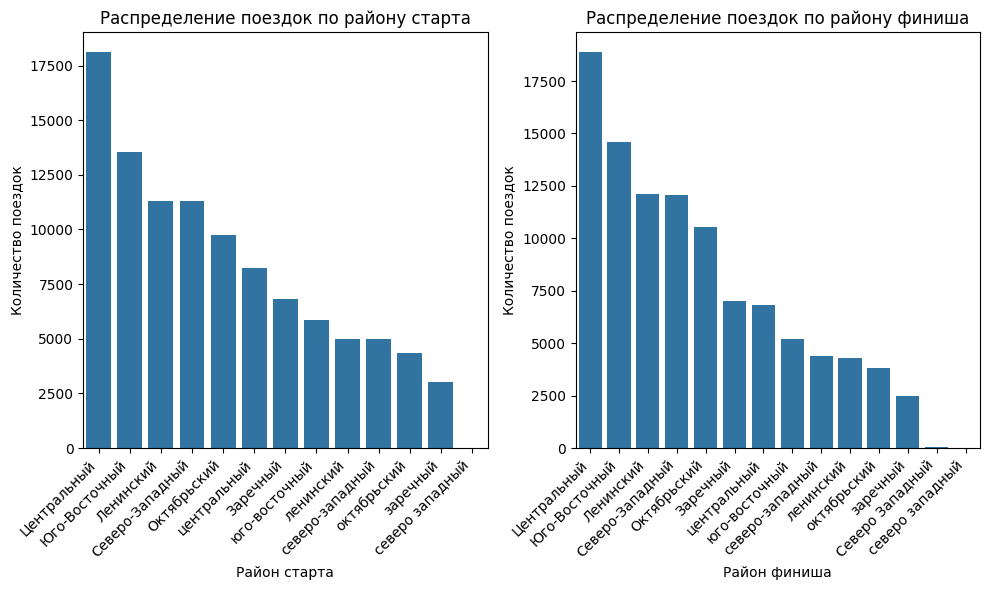

In [329]:
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=df_rides, x='start_district', order=df_rides['start_district'].value_counts().index)
plt.title('Распределение поездок по району старта')
plt.xlabel('Район старта')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
sns.countplot(data=df_rides, x='end_district', order=df_rides['end_district'].value_counts().index)
plt.title('Распределение поездок по району финиша')
plt.xlabel('Район финиша')
plt.ylabel('Количество поездок')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Также исходя из графика мы видим, что есть опечатки в виде отсутствия "-", а также неправильного регистра.

In [330]:
df_rides["start_location"].unique()[:30]

array(['Шевченко', 'Чехова', 'Буденного', 'Труда', 'Первомайская',
       'Лесная', 'Пролетарская', 'Комарова', 'Западная', 'Свободы',
       'Коммунальная', 'Зеленая', 'Шоссейная', 'Центральная', 'буденного',
       'новая', 'Энтузиастов', 'ул.подгорная', 'Восточная', 'Лермонтова',
       'Школьная', 'Пушкина', 'подгорная', 'рябиновая', 'Солнечная',
       'Мичурина', 'ул труда', 'Партизанская', 'Вокзальная',
       'Комсомольская'], dtype=object)

In [331]:
df_rides["end_location"].unique()[:30]

array(['Майская', 'Спортивная', 'Суворова', 'Рабочая', 'Юбилейная',
       'Западная', 'Свободы', 'ул. западная', 'Озерная', 'ул. чкалова',
       'Строителей', 'ул. спортивная', 'Красная', 'Ул. Крупской',
       'ул.почтовая', 'гоголя', 'Сиреневая', 'ул.южная', 'Шоссейная',
       'Трудовая', 'Дружбы', 'Почтовая', 'Южная', 'космонавтов',
       'шевченко', 'ул. набережная', 'вишневая', 'Совхозная',
       'ул сосновая', 'ул. вишневая'], dtype=object)

видим опечатки связанные с присутствием/отсуствием ул.
так что уберём ул и точки из всех улиц

#### Датасет погоды

In [332]:
df_weather.head(5)

datetime  temperature  precipitation_total  wind_gust  \
0  2023-04-01T00:00:00     8.740245                  0.1      48.60   
1  2023-04-01T01:00:00     9.040245                  0.2      55.44   
2  2023-04-01T02:00:00     8.880245                  0.3      55.80   
3  2023-04-01T03:00:00     8.690246                  0.3      55.44   
4  2023-04-01T04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  
0   21.638964               90.0                0.0  
1   22.493519               74.0                0.0  
2   22.264770               72.0                0.0  
3   21.945240               77.0                0.0  
4   22.424270               78.0                0.0

In [333]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   datetime             3672 non-null   object 
 1   temperature          3617 non-null   float64
 2   precipitation_total  3642 non-null   float64
 3   wind_gust            3672 non-null   float64
 4   wind_speed           3656 non-null   float64
 5   cloud_cover_total    3652 non-null   float64
 6   sunshine_duration    3660 non-null   float64
dtypes: float64(6), object(1)
memory usage: 200.9+ KB


Размер датасета, а значит и количество измерений

In [334]:
df_weather.shape

(3672, 7)

найдём количество месяцев измерений

In [335]:
df_weather.shape[0] / 24 / 30

5.1

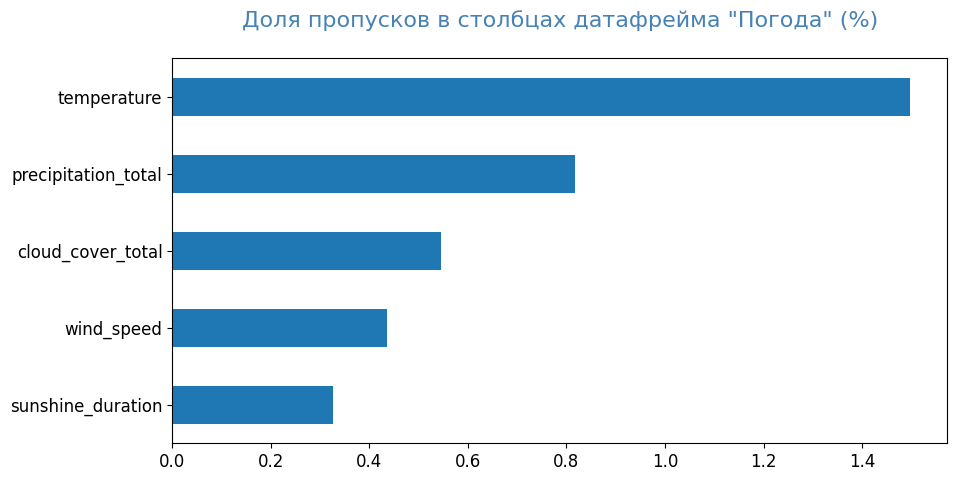

In [336]:
pass_value_barh(df_weather, "Погода")

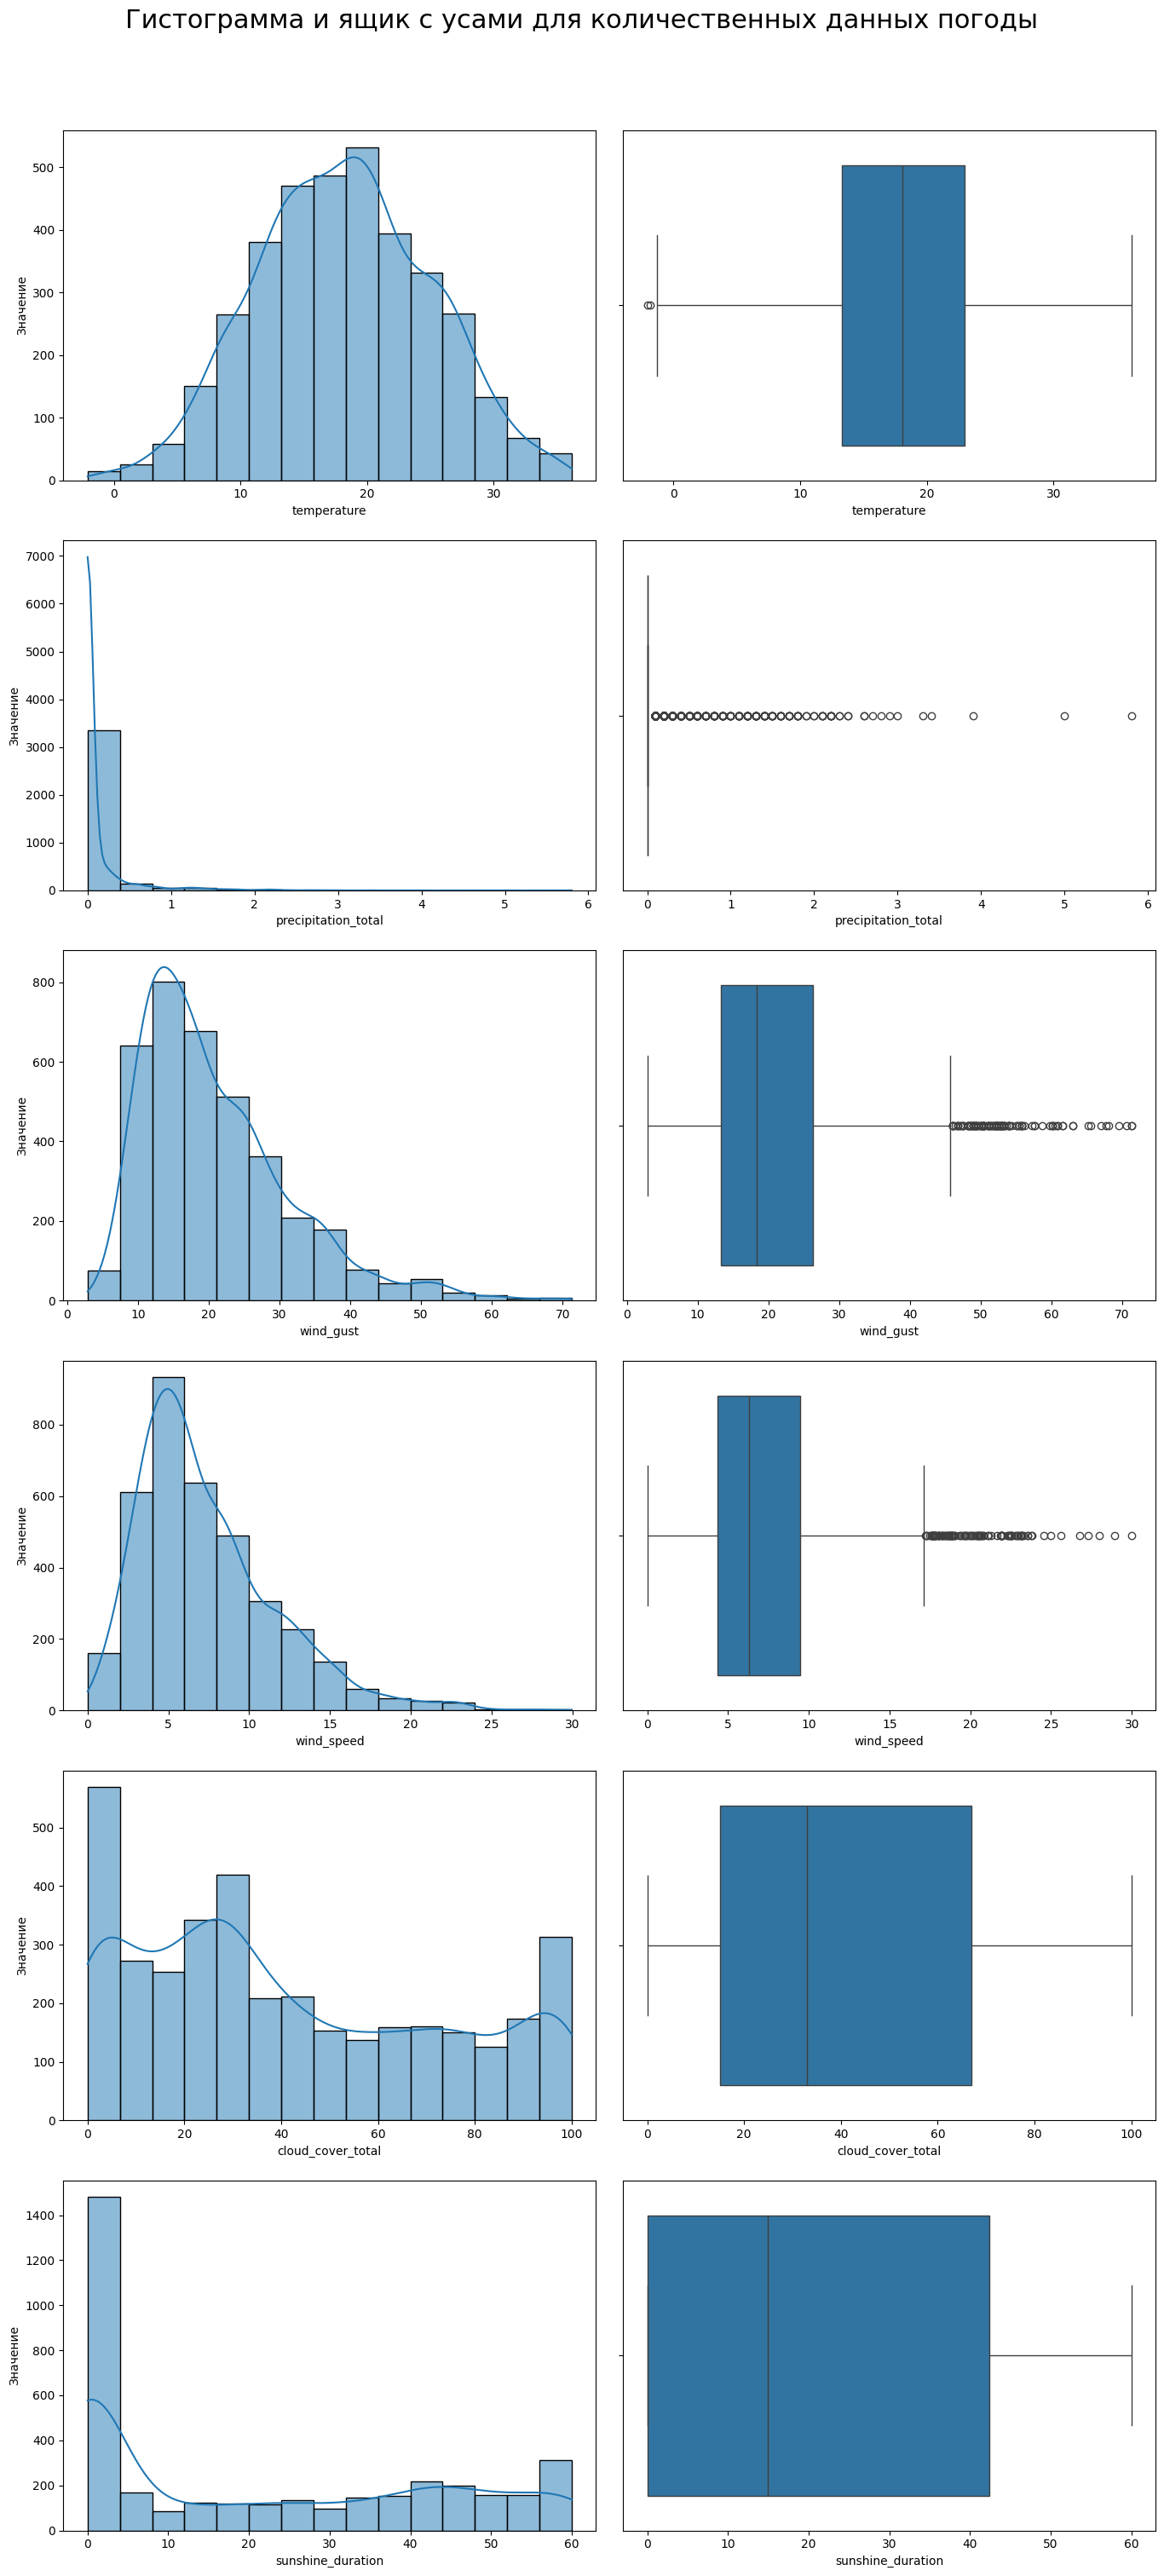

In [337]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

### Исправление опечаток

In [338]:
for x in ["start_location", "end_location"]:
    df_rides = streets_format(df_rides, x)

for x in ["start_district", "end_district"]:
    df_rides = rayons_format(df_rides, x)

### Назначение типов данных

In [339]:
df_rides["promo"] = df_rides["promo"].astype(bool)
df_rides["start_date"] = pd.to_datetime(df_rides["start_date"])
df_rides["end_date"] = pd.to_datetime(df_rides["end_date"])
df_weather["datetime"] = pd.to_datetime(df_weather["datetime"])

### Работа с пропусками и выбросами в датасете поездок

####Выбросы

In [340]:
df_rides["duration"] = (df_rides["end_date"] - df_rides["start_date"]).apply(
    lambda x: x.total_seconds() / 60
)
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000  
1         заречный   спортивная      октябрьский    4515.0  False  28.416667  
2      октябрьский     суворова        ленинский    4520.0  False  38.316667  
3      центральный      рабочая  северо-западный    3881.0  False  31.816667  
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667

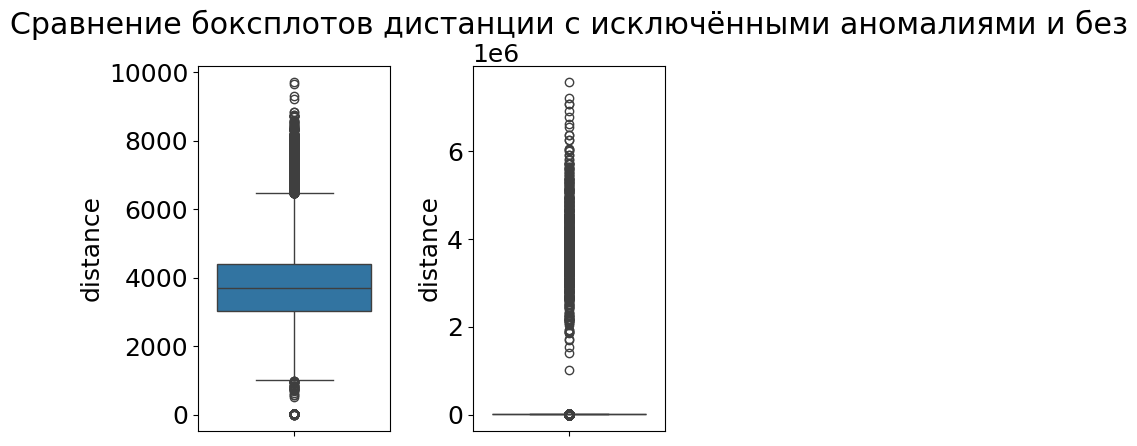

In [341]:
# Создаем два подграфика для сравнения распределения дистанции
plt.subplot(1, 2, 1)
# Строим boxplot для дистанций, исключая аномально большие значения (более 1,000,000)
sns.boxplot(df_rides[df_rides["distance"] < 1000000]["distance"])
# Создаем второй boxplot для всех дистанций, чтобы увидеть общую картину и выбросы
plt.subplot(1, 2, 2)
sns.boxplot(df_rides["distance"])
plt.title('Сравнение боксплотов дистанции с исключёнными аномалиями и без')
plt.tight_layout() # Added to prevent plots from overlapping
plt.show()

In [342]:
print(df_rides[df_rides["distance"] > 1000000]["distance"].shape[0], df_rides.shape[0])

622 102255


Выбросы по параметру distance начинаются с 1E6, остальные значения напоминают реальные (поездки на самокате в среднем около 4км, >=100км на самокате не проехать), выбросы по параметру distance можно заменить на среднее по группам

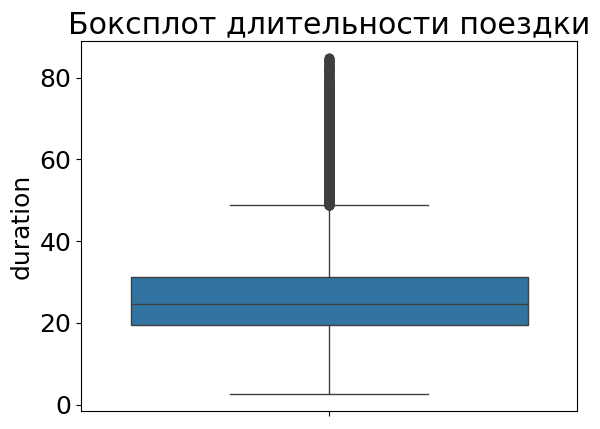

In [343]:
sns.boxplot(df_rides["duration"])
plt.title('Боксплот длительности поездки')
plt.show()

*   Пропуски есть только в 2 базовых столбцах - дистанция и
время окончания

*   Выбросы есть только в столбце distance, в этих столбцах можно просто заменить на среднее по группе (место и район старта и место и район финиша)

/tmp/ipython-input-3190274099.py:225: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[(x > 1000000) | (x < 10)] = None


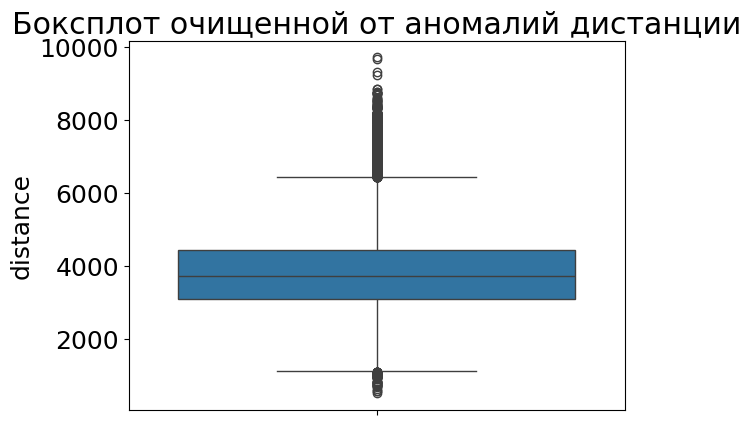

In [344]:
df_rides["distance"] = df_rides["distance"].transform(ejection)
sns.boxplot(df_rides["distance"])
plt.title('Боксплот очищенной от аномалий дистанции')
plt.show()

####Пропуски

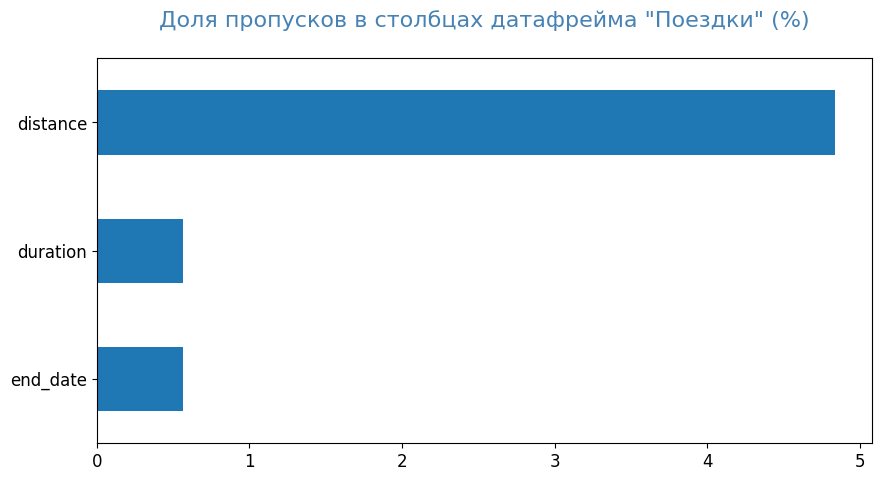

In [345]:
pass_value_barh(df_rides, "Поездки")

Найдём значения средней скорости поездки (метров в миунут) по группам и при помощи него зменим пропуски в дистанции.

In [346]:
df_rides["avg_speed"] = df_rides["distance"] / df_rides["duration"]
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  \
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000   
1         заречный   спортивная      октябрьский    4515.0  False  28.416667   
2      октябрьский     суворова        ленинский    4520.0  False  38.316667   
3      центральный      рабочая  северо-западный    3881.0  False  31.816667   
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667   

    avg_speed  
0  171.687764  
1  158.885630  
2  117.964332  
3  121.980094  
4  131.380435

In [347]:
df_rides = df_rides.drop_duplicates(subset=["id"])

In [348]:
df_rides["avg_speed"] = df_rides.groupby(
    ["start_location", "start_district", "end_location", "end_district"]
)["avg_speed"].transform(
    lambda x: x.fillna(df_rides["avg_speed"].mean() if x.count() == 0 else x.mean())
)

df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  \
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000   
1         заречный   спортивная      октябрьский    4515.0  False  28.416667   
2      октябрьский     суворова        ленинский    4520.0  False  38.316667   
3      центральный      рабочая  северо-западный    3881.0  False  31.816667   
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667   

    avg_speed  
0  171.687764  
1  158.885630  
2  117.964332  
3  121.980094  
4  131.380435

In [349]:
df_rides["distance"] = df_rides["distance"].fillna(
    df_rides["duration"] * df_rides["avg_speed"]
)
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  \
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000   
1         заречный   спортивная      октябрьский    4515.0  False  28.416667   
2      октябрьский     суворова        ленинский    4520.0  False  38.316667   
3      центральный      рабочая  северо-западный    3881.0  False  31.816667   
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667   

    avg_speed  
0  171.687764  
1  158.885630  
2  117.964332  
3  121.980094  
4  131.380435

In [350]:
df_rides[df_rides["distance"].isna() & df_rides["duration"].isna()].shape[0]

18

In [351]:
df_rides[df_rides["distance"].isna()]

id          start_date end_date start_location   start_district  \
495     100807 2023-04-22 17:58:05      NaT     ломоносова      октябрьский   
2546    102752 2023-04-24 19:41:16      NaT    октябрьская         заречный   
2806    103006 2023-04-25 08:47:46      NaT      восточная      октябрьский   
10158   110004 2023-05-03 18:18:24      NaT  комсомольская         заречный   
15582   115182 2023-05-09 13:11:54      NaT         гоголя      центральный   
16517   116078 2023-05-10 18:54:16      NaT       мичурина        ленинский   
21876   121178 2023-05-16 18:30:32      NaT        майская      октябрьский   
27939   126949 2023-05-23 06:44:52      NaT       крупской      центральный   
46102   144250 2023-06-09 21:59:33      NaT    энтузиастов      центральный   
46473   144602 2023-06-10 11:46:28      NaT     спортивная      октябрьский   
56077   153746 2023-06-18 20:30:51      NaT        красная  северо-западный   
56264   153920 2023-06-18 22:29:02      NaT        майская      октябрьский   
63068   160370 2023-06-25 18:50:41      NaT        майская      октябрьский   
67429   164516 2023-06-30 12:34:19      NaT     пионерская         заречный   
73568   170383 2023-07-06 07:40:33      NaT   пролетарская      центральный   
96091   191845 2023-07-26 17:29:08      NaT      березовая  северо-западный   
101961  197428 2023-07-31 19:16:20      NaT          южная      центральный   
102108  197572 2023-07-31 20:51:23      NaT      юбилейная    юго-восточный   

        end_location     end_district  distance  promo  duration   avg_speed  
495        цветочная  северо-западный       NaN  False       NaN  161.769014  
2546        комарова        ленинский       NaN  False       NaN  147.591056  
2806    строительная  северо-западный       NaN  False       NaN  142.927047  
10158      заводская  северо-западный       NaN  False       NaN  158.311131  
15582       дорожная    юго-восточный       NaN  False       NaN  148.929230  
16517      восточная      октябрьский       NaN  False       NaN  154.040510  
21876       гагарина      центральный       NaN  False       NaN  145.933047  
27939      буденного      октябрьский       NaN  False       NaN  175.021465  
46102     спортивная      октябрьский       NaN  False       NaN  157.147814  
46473          труда      центральный       NaN  False       NaN  156.840155  
56077    центральная    юго-восточный       NaN  False       NaN  161.779865  
56264      восточная      октябрьский       NaN  False       NaN  154.738058  
63068       вишневая    юго-восточный       NaN  False       NaN  158.377185  
67429         чехова         заречный       NaN  False       NaN  146.393028  
73568      береговая      центральный       NaN  False       NaN  156.117562  
96091      береговая      центральный       NaN  False       NaN  144.747650  
101961       чапаева  северо-западный       NaN  False       NaN  152.925776  
102108      дорожная    юго-восточный       NaN  False       NaN  180.423302

Существует 18 записей, где пропущена и дистанция и end_date, можно убрать их как статистический выброс, так как записи ничего не объединяет

In [352]:
df_rides = df_rides.dropna(subset=["distance"])

Пропуски в end_date найдём как: start_date + duration

In [353]:
df_rides["duration"] = df_rides["duration"].fillna(
    df_rides["distance"] / df_rides["avg_speed"]
)
df_rides["end_date"] = df_rides.apply(
    lambda row: (
        row["start_date"] + dt.timedelta(seconds=int(row["duration"] * 60))
        if pd.isna(row["end_date"])
        else row["end_date"]
    ),
    axis=1,
)
df_rides.head()

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  \
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000   
1         заречный   спортивная      октябрьский    4515.0  False  28.416667   
2      октябрьский     суворова        ленинский    4520.0  False  38.316667   
3      центральный      рабочая  северо-западный    3881.0  False  31.816667   
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667   

    avg_speed  
0  171.687764  
1  158.885630  
2  117.964332  
3  121.980094  
4  131.380435

### Работа с пропусками и выбросами в датасете погоды

#### Выбросы

In [354]:
df_weather.head()

datetime  temperature  precipitation_total  wind_gust  \
0 2023-04-01 00:00:00     8.740245                  0.1      48.60   
1 2023-04-01 01:00:00     9.040245                  0.2      55.44   
2 2023-04-01 02:00:00     8.880245                  0.3      55.80   
3 2023-04-01 03:00:00     8.690246                  0.3      55.44   
4 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  
0   21.638964               90.0                0.0  
1   22.493519               74.0                0.0  
2   22.264770               72.0                0.0  
3   21.945240               77.0                0.0  
4   22.424270               78.0                0.0

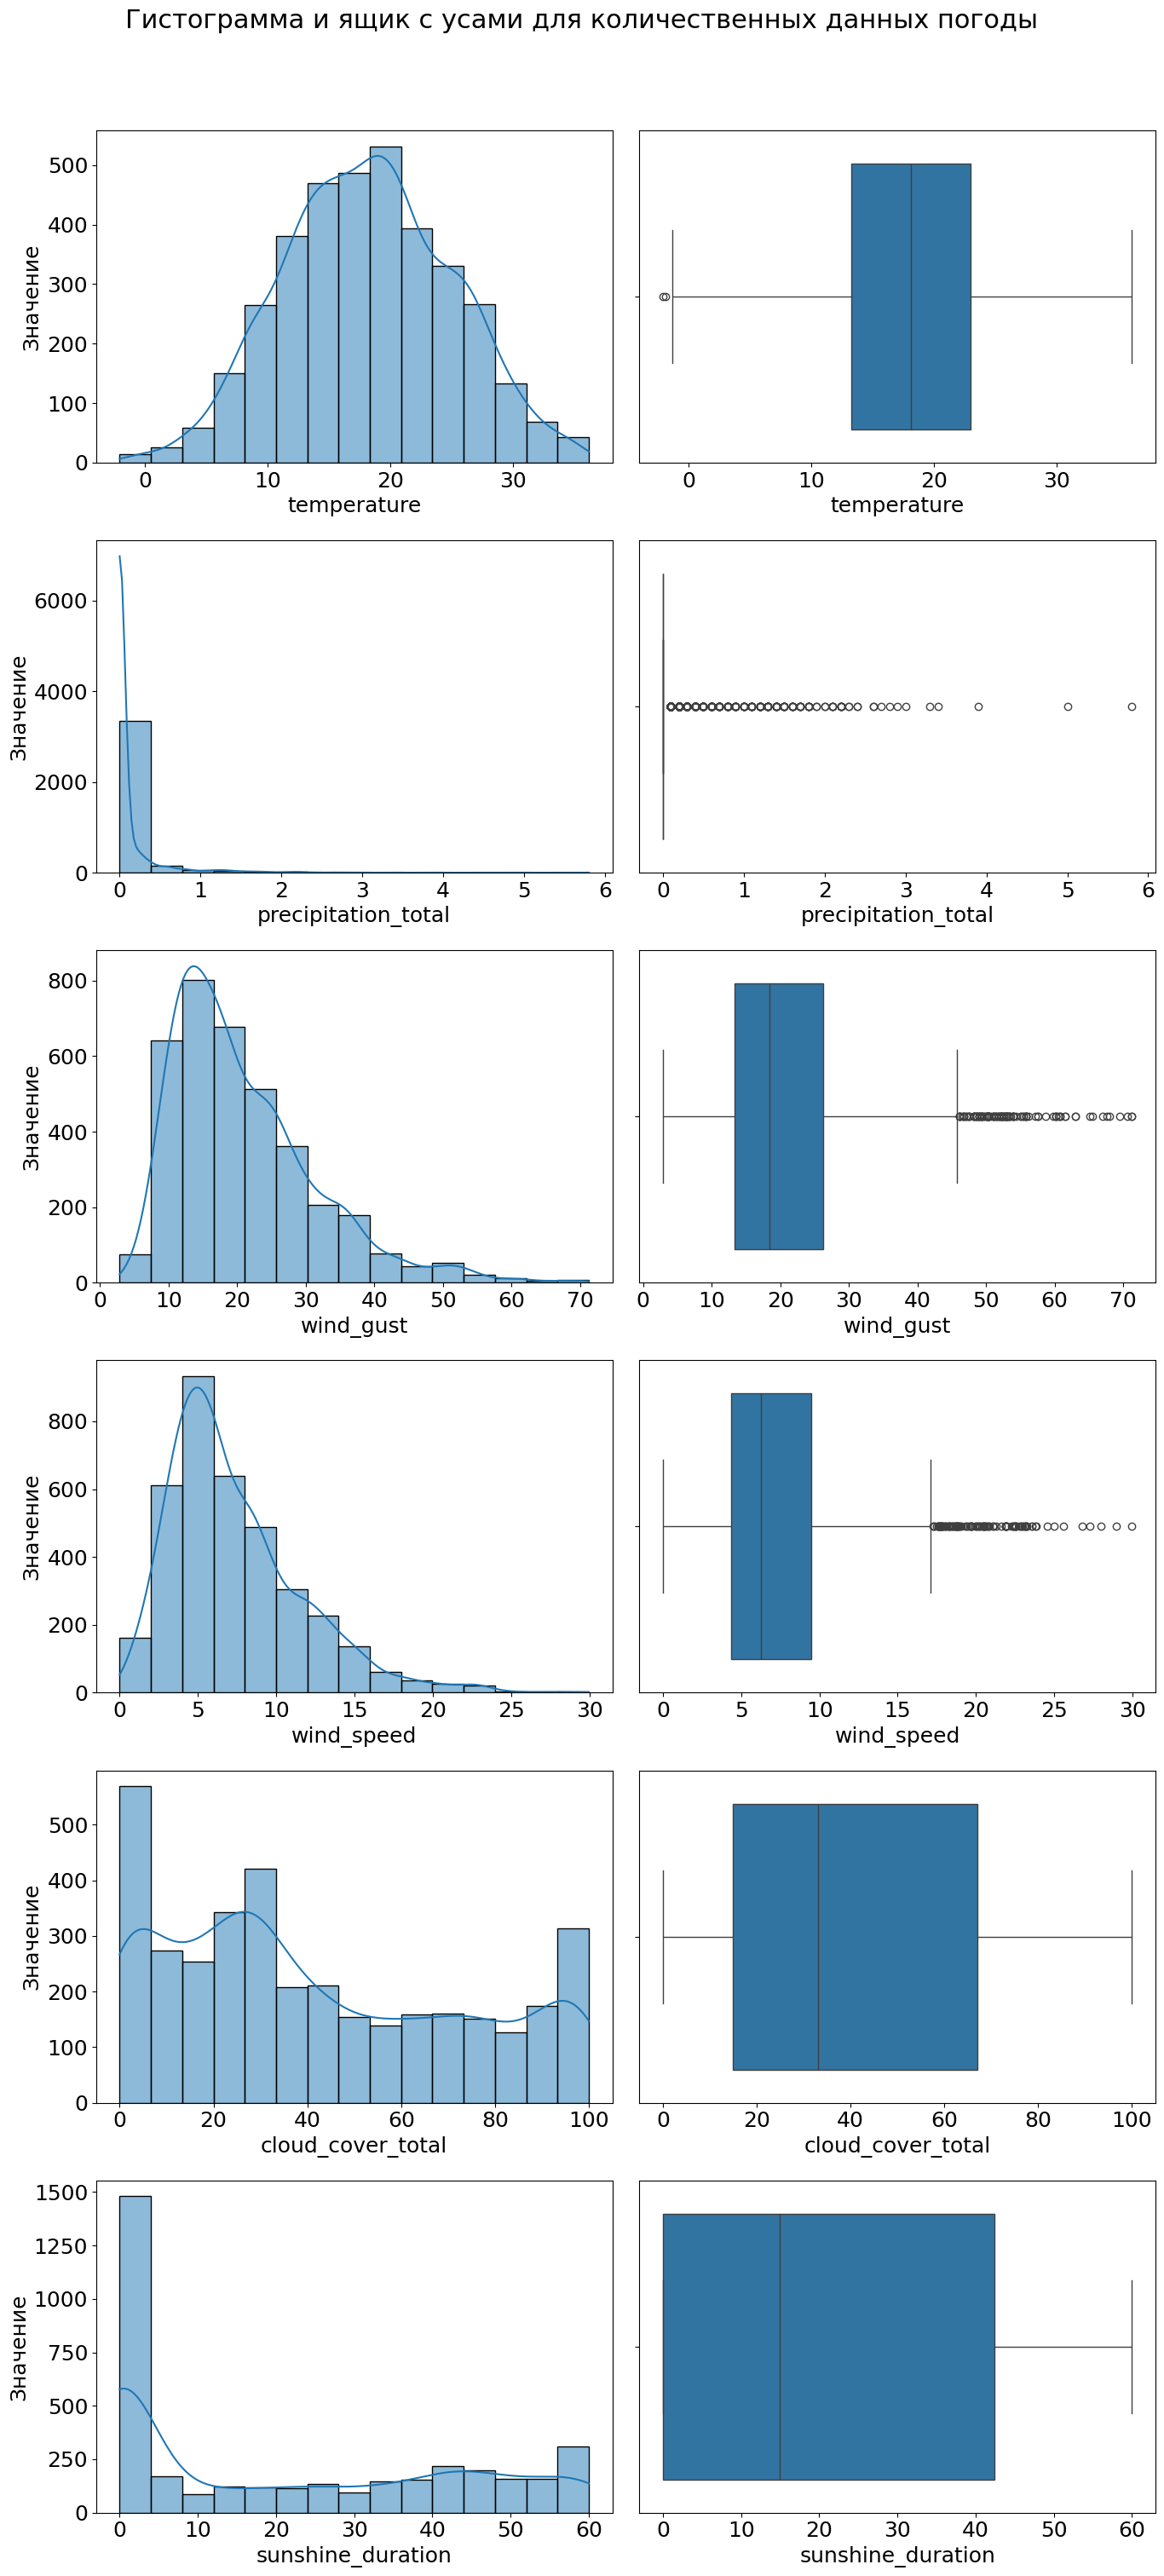

In [355]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

In [356]:
df_weather.describe()

datetime  temperature  precipitation_total  \
count                           3672  3617.000000          3642.000000   
mean   2023-06-16 11:30:00.000000256    18.137779             0.101043   
min              2023-04-01 00:00:00    -2.079755             0.000000   
25%              2023-05-09 05:45:00    13.270246             0.000000   
50%              2023-06-16 11:30:00    18.100245             0.000000   
75%              2023-07-24 17:15:00    23.010244             0.000000   
max              2023-08-31 23:00:00    36.150246             5.800000   
std                              NaN     6.848331             0.343670   

         wind_gust   wind_speed  cloud_cover_total  sunshine_duration  
count  3672.000000  3656.000000        3652.000000        3660.000000  
mean     20.886568     7.345096          41.056216          21.502410  
min       2.880000     0.000000           0.000000           0.000000  
25%      13.320000     4.334974          15.000001           0.000000  
50%      18.359999     6.287130          33.000000          14.919949  
75%      26.280000     9.449572          67.000000          42.454547  
max      71.280000    29.966620         100.000000          60.000000  
std      10.436531     4.265649          31.318514          21.896528

In [357]:
df_weather[df_weather["wind_gust"] > 60]

datetime  temperature  precipitation_total  wind_gust  \
8    2023-04-01 08:00:00     8.640245                  0.5  63.000000   
9    2023-04-01 09:00:00     8.730246                  0.6  60.120003   
10   2023-04-01 10:00:00     9.150246                  0.6  60.120003   
13   2023-04-01 13:00:00    10.620245                  0.4  60.479996   
278  2023-04-12 14:00:00    13.800245                  1.4  63.000000   
279  2023-04-12 15:00:00    12.250245                  0.9  60.839996   
2963 2023-08-02 11:00:00    25.760244                  0.0  68.039990   
2964 2023-08-02 12:00:00    26.970245                  0.0  71.280000   
2965 2023-08-02 13:00:00    27.540245                  0.0  70.560000   
2966 2023-08-02 14:00:00    27.630245                  0.0  61.560000   
2969 2023-08-02 17:00:00    24.320246                  0.3  69.479996   
2970 2023-08-02 18:00:00    22.510244                  0.5  67.679990   
2971 2023-08-02 19:00:00    21.750246                  0.4  71.280000   
2985 2023-08-03 09:00:00    20.400246                  0.0  65.520004   
2986 2023-08-03 10:00:00    21.160246                  0.0  66.960000   
2987 2023-08-03 11:00:00    21.510244                  0.0  65.159996   
2988 2023-08-03 12:00:00    22.140245                  0.0  60.839996   
3063 2023-08-06 15:00:00          NaN                  0.1  61.560000   
3064 2023-08-06 16:00:00          NaN                  0.4  60.120003   

      wind_speed  cloud_cover_total  sunshine_duration  
8      20.371038               92.0           4.242425  
9      23.838959               88.0           6.666666  
10     23.199759               98.0           0.606061  
13     18.472595               98.0           0.606061  
278    18.837324               98.0           0.606061  
279    17.884428               80.0           9.696970  
2963   29.966620               81.0          10.909091  
2964   28.008370               80.0          11.515152  
2965   24.985659               70.0          17.575756  
2966   27.288855               61.0          23.030302  
2969   22.870626               68.0          18.787880  
2970   21.267440               86.0           7.878789  
2971   22.553936               28.0          43.030300  
2985   22.553936               32.0          40.606064  
2986   23.773632               91.0           4.848486  
2987   21.924562               63.0          21.818182  
2988   25.600533               55.0          26.666664  
3063   20.833395               71.0          16.969696  
3064   19.708150               45.0          32.727272

In [358]:
df_weather[df_weather["datetime"].dt.date == dt.date(2023, 8, 2)]

datetime  temperature  precipitation_total  wind_gust  \
2952 2023-08-02 00:00:00    15.580245                  0.0  18.720000   
2953 2023-08-02 01:00:00    15.180245                  0.0  17.640000   
2954 2023-08-02 02:00:00    15.920245                  0.0  18.000000   
2955 2023-08-02 03:00:00    16.160246                  0.4  19.080000   
2956 2023-08-02 04:00:00    16.270247                  0.5  19.080000   
2957 2023-08-02 05:00:00    16.170246                  0.3  23.039999   
2958 2023-08-02 06:00:00    16.590246                  0.6  31.319998   
2959 2023-08-02 07:00:00    17.250246                  0.8  30.599998   
2960 2023-08-02 08:00:00    19.030245                  0.3  34.920000   
2961 2023-08-02 09:00:00    21.510244                  0.0  38.880000   
2962 2023-08-02 10:00:00    23.900246                  0.0  49.320000   
2963 2023-08-02 11:00:00    25.760244                  0.0  68.039990   
2964 2023-08-02 12:00:00    26.970245                  0.0  71.280000   
2965 2023-08-02 13:00:00    27.540245                  0.0  70.560000   
2966 2023-08-02 14:00:00    27.630245                  0.0  61.560000   
2967 2023-08-02 15:00:00    27.620245                  0.0  52.920000   
2968 2023-08-02 16:00:00    26.090246                  0.4  53.280000   
2969 2023-08-02 17:00:00    24.320246                  0.3  69.479996   
2970 2023-08-02 18:00:00    22.510244                  0.5  67.679990   
2971 2023-08-02 19:00:00    21.750246                  0.4  71.280000   
2972 2023-08-02 20:00:00    20.780245                  0.2  52.920000   
2973 2023-08-02 21:00:00    20.120245                  0.0  53.280000   
2974 2023-08-02 22:00:00    19.360245                  0.0  51.480000   
2975 2023-08-02 23:00:00    19.220245                  0.0  51.120000   

      wind_speed  cloud_cover_total  sunshine_duration  
2952    6.569383               98.0           0.000000  
2953    7.952660               92.0           0.000000  
2954    7.771331               98.0           0.000000  
2955    8.654986              100.0           0.000000  
2956    7.421590              100.0           0.000000  
2957    8.209263              100.0           0.000000  
2958   10.390226              100.0           0.000000  
2959   10.895577              100.0           0.000000  
2960   12.324414               97.0           1.212122  
2961   13.450708               47.0          31.515150  
2962   28.954834               90.0           5.454544  
2963   29.966620               81.0          10.909091  
2964   28.008370               80.0          11.515152  
2965   24.985659               70.0          17.575756  
2966   27.288855               61.0          23.030302  
2967   26.758923               67.0          19.393942  
2968   22.383780               76.0          13.939394  
2969   22.870626               68.0          18.787880  
2970   21.267440               86.0           7.878789  
2971   22.553936               28.0          43.030300  
2972   23.565567               24.0           4.204546  
2973   22.354810               36.0           0.000000  
2974   21.900904               25.0           0.000000  
2975   20.523157               54.0           0.000000

Все данные выглядят достаточно реально, оснований для подозрений на выбросы нет

скорость ветра в 29 км/ч по шкале Бофорта считается свежим ветром

порывы ветра до 71 км/ч также допустимы, учитывая что ветер был неслабым в эти дни, а также облачность на высоком уровне. Логично предположить, что это ураганные дни. Эта информация будет полезна в дальнейшем

#### Пропуски

In [359]:
df_weather.head()

datetime  temperature  precipitation_total  wind_gust  \
0 2023-04-01 00:00:00     8.740245                  0.1      48.60   
1 2023-04-01 01:00:00     9.040245                  0.2      55.44   
2 2023-04-01 02:00:00     8.880245                  0.3      55.80   
3 2023-04-01 03:00:00     8.690246                  0.3      55.44   
4 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  
0   21.638964               90.0                0.0  
1   22.493519               74.0                0.0  
2   22.264770               72.0                0.0  
3   21.945240               77.0                0.0  
4   22.424270               78.0                0.0

In [360]:
df_weather.duplicated(subset="datetime").value_counts()

False    3672
Name: count, dtype: int64

дубликатов нет

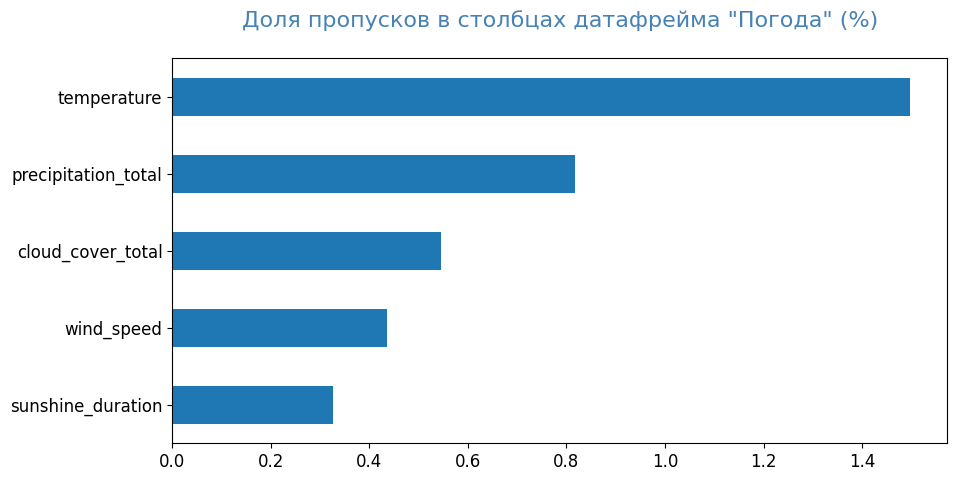

In [361]:
pass_value_barh(df_weather, "Погода")

In [362]:
df_weather = df_weather.interpolate(method="linear")

Интерполяция наиболее предпочтительна для данных, т.к. погода меняется постепенно и взаимосвязана по времени

Пропусков нет


Text(0.5, 1.0, 'Пропуски')

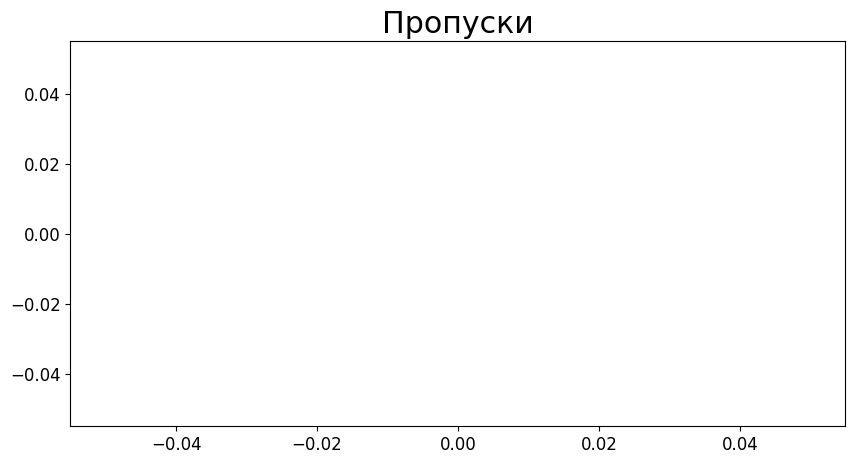

In [363]:
pass_value_barh(df_weather, "Погода")
plt.title('Пропуски')

### Аналитический и графический анализ

#### Посмотрим на неявные аномалии после предобработки

In [364]:
print(df_rides['avg_speed'].describe())


count    97354.000000
mean       153.191047
std         33.178950
min         37.999551
25%        131.425929
50%        153.106085
75%        174.701919
max        318.712871
Name: avg_speed, dtype: float64


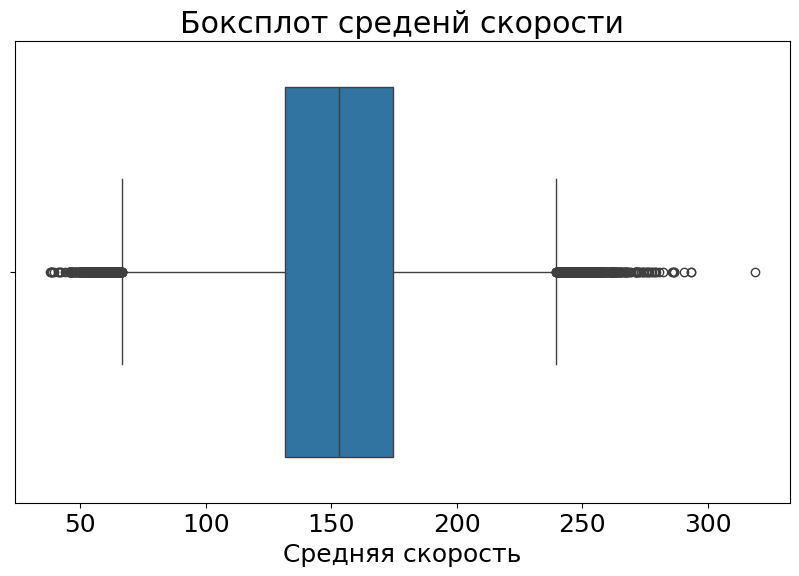

In [365]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_rides['avg_speed'])
plt.title('Боксплот среденй скорости')
plt.xlabel('Средняя скорость')
plt.show()

In [366]:
Q1 = df_rides['avg_speed'].quantile(0.25)
Q3 = df_rides['avg_speed'].quantile(0.75)
IQR = Q3 - Q1
print(f'Q1 (25th percentile): {Q1:.2f}')
print(f'Q3 (75th percentile): {Q3:.2f}')
print(f'IQR (Interquartile Range): {IQR:.2f}')

Q1 (25th percentile): 131.43
Q3 (75th percentile): 174.70
IQR (Interquartile Range): 43.28


In [367]:
upper_bound = Q3 + 3 * IQR
lower_bound = Q1 - 1.5 * IQR
print(f'Верхняя граница: {upper_bound:.2f}')
print(f'Нижняя граница: {lower_bound:.2f}')

Верхняя граница: 304.53
Нижняя граница: 66.51


In [368]:
anomalous_rides = df_rides[(df_rides['avg_speed'] < lower_bound) | (df_rides['avg_speed'] > upper_bound)]
print(f'Количество ненормальных поездок по статистике: {len(anomalous_rides)}')
display(anomalous_rides.head(10))

Количество ненормальных поездок по статистике: 382


id          start_date            end_date start_location  \
161   100493 2023-04-22 13:26:15 2023-04-22 14:05:01       калинина   
420   100736 2023-04-22 16:57:19 2023-04-22 17:51:41      колхозная   
435   100751 2023-04-22 17:09:36 2023-04-22 18:23:37         речная   
564   100874 2023-04-22 18:37:57 2023-04-22 19:43:22      цветочная   
831   101127 2023-04-22 21:08:18 2023-04-22 22:25:35   коммунальная   
1201  101478 2023-04-23 11:35:33 2023-04-23 12:12:30        свободы   
1644  101898 2023-04-23 18:11:44 2023-04-23 19:11:44       заречная   
1947  102187 2023-04-23 22:12:31 2023-04-23 23:22:11        пушкина   
2180  102406 2023-04-24 10:54:34 2023-04-24 12:06:21   строительная   
2508  102714 2023-04-24 19:11:01 2023-04-24 20:14:03      буденного   

       start_district   end_location   end_district  distance  promo  \
161         ленинский         кирова      ленинский    2359.0  False   
420         ленинский       дорожная  юго-восточный    3556.0  False   
435     юго-восточный     спортивная    октябрьский    4466.0  False   
564   северо-западный  комсомольская       заречный    4134.0  False   
831     юго-восточный        пушкина    центральный    4126.0  False   
1201        ленинский       комарова      ленинский    2308.0  False   
1644    юго-восточный    октябрьская       заречный    3977.0  False   
1947      центральный     строителей    центральный    3914.0  False   
2180  северо-западный      шоссейная       заречный    3614.0  False   
2508      октябрьский      буденного    октябрьский    2418.0  False   

       duration  avg_speed  
161   38.766667  60.851247  
420   54.366667  65.407725  
435   74.016667  60.337762  
564   65.416667  63.194904  
831   77.283333  53.387966  
1201  36.950000  62.462788  
1644  60.000000  66.283333  
1947  69.666667  56.181818  
2180  71.783333  50.345948  
2508  63.033333  38.360656

> Выброс со сликшом большой скоростью только 1 и при этом он логически возможен.
>
> Выбросы со слишком маленькой скоростью являются менее логичными, но возможными по какой либо причине.

**Исходя из этого можно сделать вывод, что в среденй скорости аномалий не наблюадется.**

#### Просмотр финальных датасетов

##### Датасет поездок

In [369]:
df_rides.head(5)

id          start_date            end_date start_location  \
0  100340 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко   
1  100341 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова   
2  100342 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного   
3  100343 2023-04-22 09:06:34 2023-04-22 09:38:23          труда   
4  100344 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская   

    start_district end_location     end_district  distance  promo   duration  \
0    юго-восточный      майская      октябрьский    4069.0  False  23.700000   
1         заречный   спортивная      октябрьский    4515.0  False  28.416667   
2      октябрьский     суворова        ленинский    4520.0  False  38.316667   
3      центральный      рабочая  северо-западный    3881.0  False  31.816667   
4  северо-западный    юбилейная    юго-восточный    4029.0  False  30.666667   

    avg_speed  
0  171.687764  
1  158.885630  
2  117.964332  
3  121.980094  
4  131.380435

In [370]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97354 entries, 0 to 102254
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              97354 non-null  int64         
 1   start_date      97354 non-null  datetime64[ns]
 2   end_date        97354 non-null  datetime64[ns]
 3   start_location  97354 non-null  object        
 4   start_district  97354 non-null  object        
 5   end_location    97354 non-null  object        
 6   end_district    97354 non-null  object        
 7   distance        97354 non-null  float64       
 8   promo           97354 non-null  bool          
 9   duration        97354 non-null  float64       
 10  avg_speed       97354 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(3), int64(1), object(4)
memory usage: 8.3+ MB


In [371]:
df_rides = df_rides.drop("id", axis=1)

т.к. id нам нужен был только для нахождения дубликатов и не поможет в дальнейшем

In [372]:
df_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 97354 entries, 0 to 102254
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   start_date      97354 non-null  datetime64[ns]
 1   end_date        97354 non-null  datetime64[ns]
 2   start_location  97354 non-null  object        
 3   start_district  97354 non-null  object        
 4   end_location    97354 non-null  object        
 5   end_district    97354 non-null  object        
 6   distance        97354 non-null  float64       
 7   promo           97354 non-null  bool          
 8   duration        97354 non-null  float64       
 9   avg_speed       97354 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(3), object(4)
memory usage: 7.5+ MB


Размер датасета, а значит и количество поездок

In [373]:
df_rides.shape[1]

10

In [374]:
df_rides["start_date"].min()

Timestamp('2023-04-22 09:01:03')

In [375]:
df_rides["start_date"].max()

Timestamp('2023-07-31 23:57:01')

нам представлены данные о поездках за 3 мес, тогда как данные о погоде за 5

In [376]:
df_rides.describe()

start_date                       end_date  \
count                          97354                          97354   
mean   2023-06-13 21:07:54.995028736  2023-06-13 21:34:17.070762496   
min              2023-04-22 09:01:03            2023-04-22 09:24:45   
25%              2023-05-20 21:43:06  2023-05-20 22:09:47.249999872   
50%       2023-06-14 15:16:29.500000            2023-06-14 15:46:14   
75%              2023-07-08 19:50:35  2023-07-08 20:19:23.249999872   
max              2023-07-31 23:57:01            2023-08-01 00:42:12   
std                              NaN                            NaN   

           distance      duration     avg_speed  
count  97354.000000  97354.000000  97354.000000  
mean    3831.604205     26.367974    153.191047  
min      519.000000      2.566667     37.999551  
25%     3103.000000     19.483333    131.425929  
50%     3734.500000     24.616667    153.106085  
75%     4452.000000     31.216667    174.701919  
max    13140.385605     84.833333    318.712871  
std     1054.170770      9.942623     33.178950

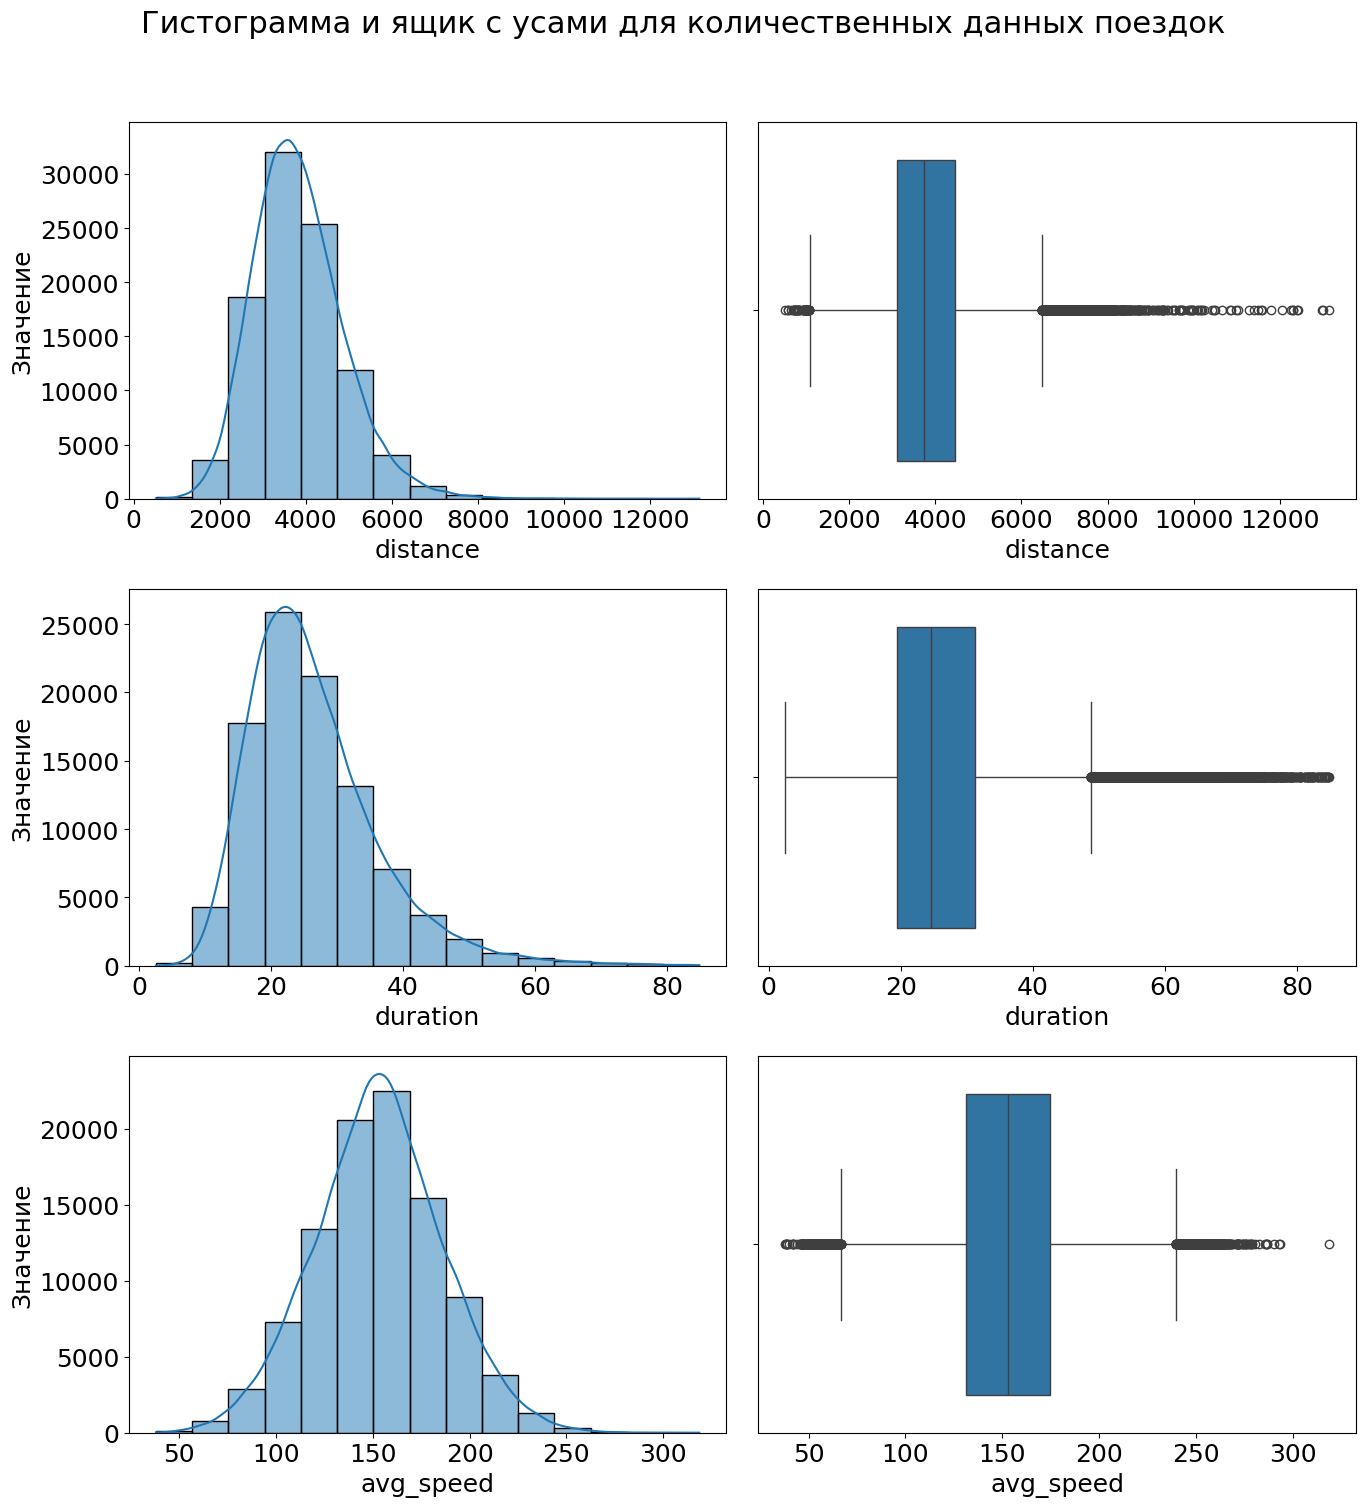

In [377]:
plot_hist(df_rides, integer_data(df_rides), "поездок")

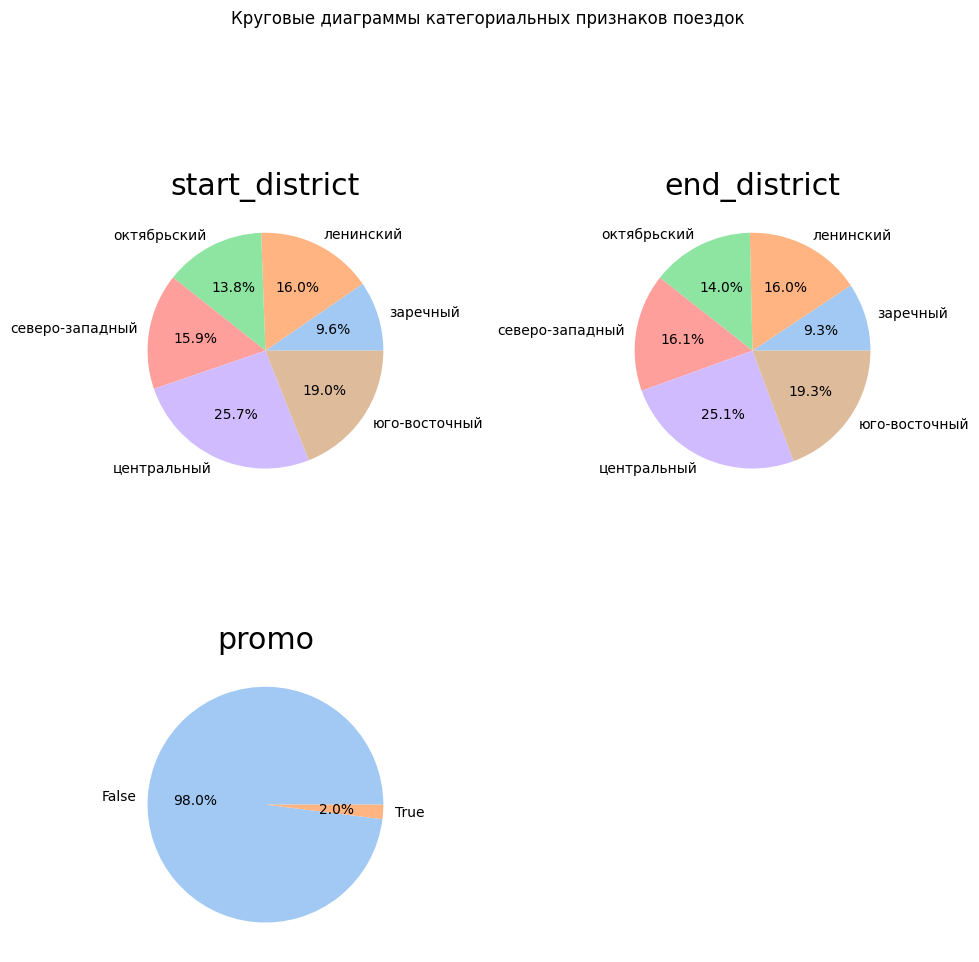

In [378]:
cat_graph(df_rides, ["start_district", "end_district", "promo"], "поездок")

##### Датасет погоды

In [379]:
df_weather.head(5)

datetime  temperature  precipitation_total  wind_gust  \
0 2023-04-01 00:00:00     8.740245                  0.1      48.60   
1 2023-04-01 01:00:00     9.040245                  0.2      55.44   
2 2023-04-01 02:00:00     8.880245                  0.3      55.80   
3 2023-04-01 03:00:00     8.690246                  0.3      55.44   
4 2023-04-01 04:00:00     8.630245                  0.3      48.96   

   wind_speed  cloud_cover_total  sunshine_duration  
0   21.638964               90.0                0.0  
1   22.493519               74.0                0.0  
2   22.264770               72.0                0.0  
3   21.945240               77.0                0.0  
4   22.424270               78.0                0.0

In [380]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3672 entries, 0 to 3671
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   datetime             3672 non-null   datetime64[ns]
 1   temperature          3672 non-null   float64       
 2   precipitation_total  3672 non-null   float64       
 3   wind_gust            3672 non-null   float64       
 4   wind_speed           3672 non-null   float64       
 5   cloud_cover_total    3672 non-null   float64       
 6   sunshine_duration    3672 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 200.9 KB


Размер датасета, а значит и количество измерений

In [381]:
df_weather.shape

(3672, 7)

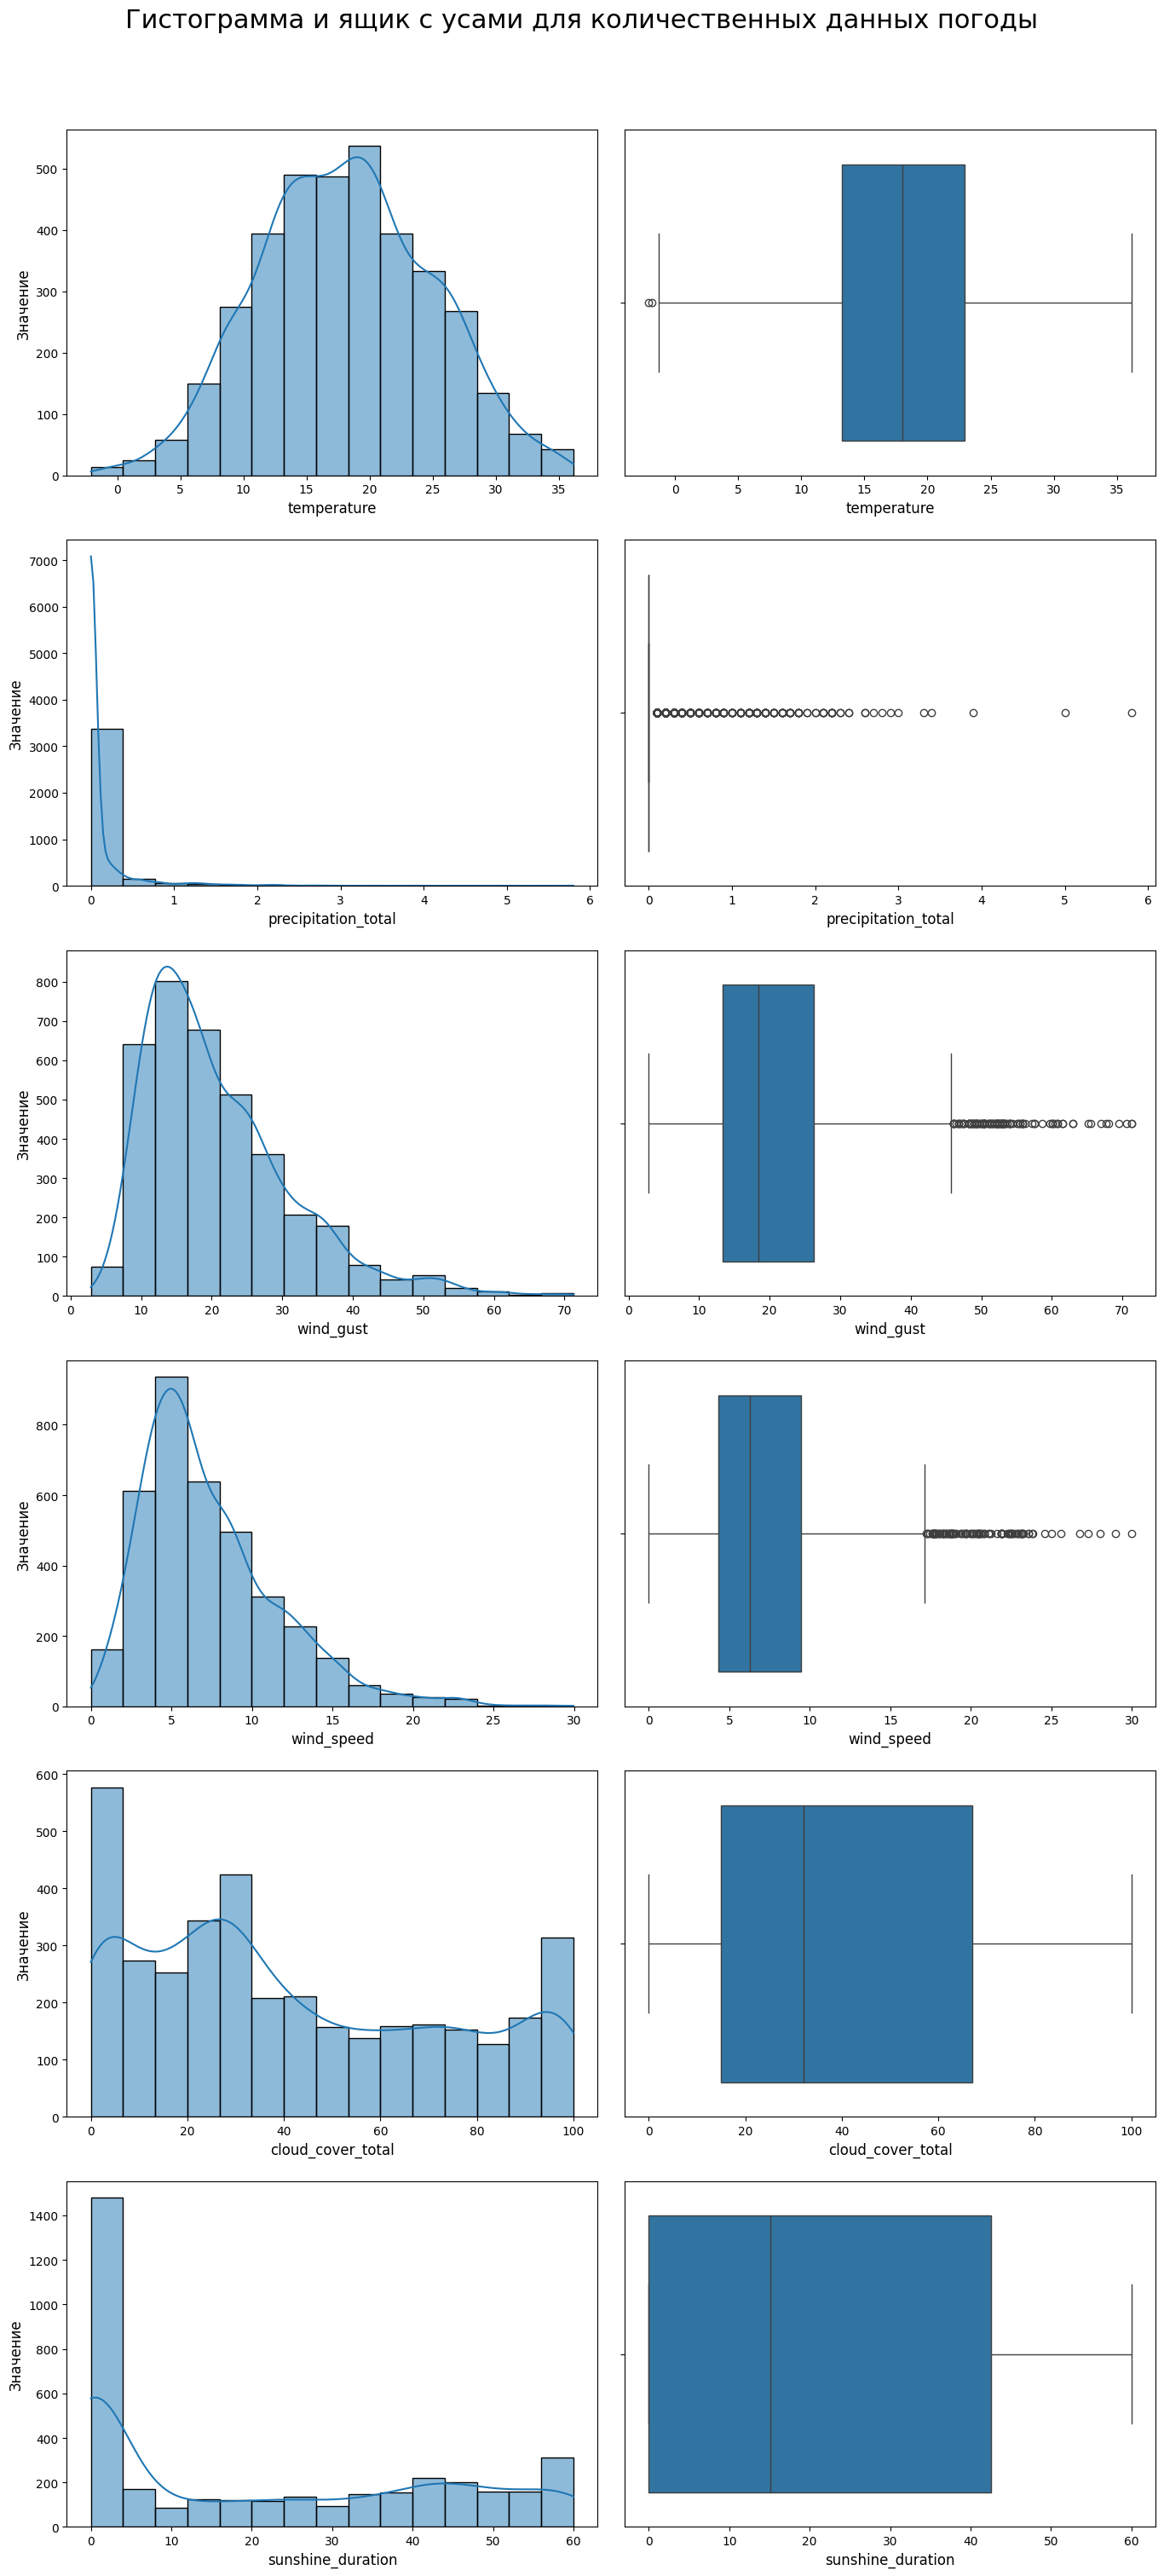

In [382]:
plot_hist(df_weather, integer_data(df_weather), "погоды")

## Выводы по EDA

1. Наиболее популярный регион для поездок - центральный, а наименее популярный - заречный

2. Было совершено 97354 поездок

3. Промокодом воспользовались в 2% поездок

4. Имеем поездки на протяжении 3 месяцев и данные об измерениях на протяжении 5

5. Средняя дистанция поездки - около 4 километров, средняя длительность 26 минут, средняя скорость 153 метра/минуту

## Расчётные задачи

### Feature engineering

Сделаем столбец с группой поездки по врмени

In [383]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour
conditions = [
    (df_rides["start_hour"] >= 1) & (df_rides["start_hour"] < 6),
    (df_rides["start_hour"] >= 6) & (df_rides["start_hour"] < 10),
    (df_rides["start_hour"] >= 10) & (df_rides["start_hour"] < 16),
    (df_rides["start_hour"] >= 16) & (df_rides["start_hour"] < 22),
    (df_rides["start_hour"] >= 22) | (df_rides["start_hour"] < 1),
]
choices = [1, 2, 3, 4, 5]
df_rides["group_of_time"] = np.select(conditions, choices)
df_rides = df_rides.drop("start_hour", axis=1)
df_rides.head()

start_date            end_date start_location   start_district  \
0 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3 2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   

  end_location     end_district  distance  promo   duration   avg_speed  \
0      майская      октябрьский    4069.0  False  23.700000  171.687764   
1   спортивная      октябрьский    4515.0  False  28.416667  158.885630   
2     суворова        ленинский    4520.0  False  38.316667  117.964332   
3      рабочая  северо-западный    3881.0  False  31.816667  121.980094   
4    юбилейная    юго-восточный    4029.0  False  30.666667  131.380435   

   group_of_time  
0              2  
1              2  
2              2  
3              2  
4              2

Далее сделаем столбец с указанием дня недели по порядку

In [384]:
df_rides["day_of_week"] = df_rides["start_date"].dt.dayofweek + 1

In [385]:
promo_rides = df_rides[df_rides['promo'] == True]
is_valid_promo = (promo_rides['group_of_time'] == 2) & (promo_rides['day_of_week'] == 1)

if is_valid_promo.all():
    print("Все поездки с True в промо соответствуют 2 группе времени и понедельнику.")
else:
    print("Есть поездки с True в промо, которые НЕ соответствуют 2 группе времени и понедельнику.")

Все поездки с True в промо соответствуют 2 группе времени и понедельнику.


Сделаем колонку с указанием периода врмени(утро, день, ночь). Для этого взглянем на график распределение активности клиентов по врмени.

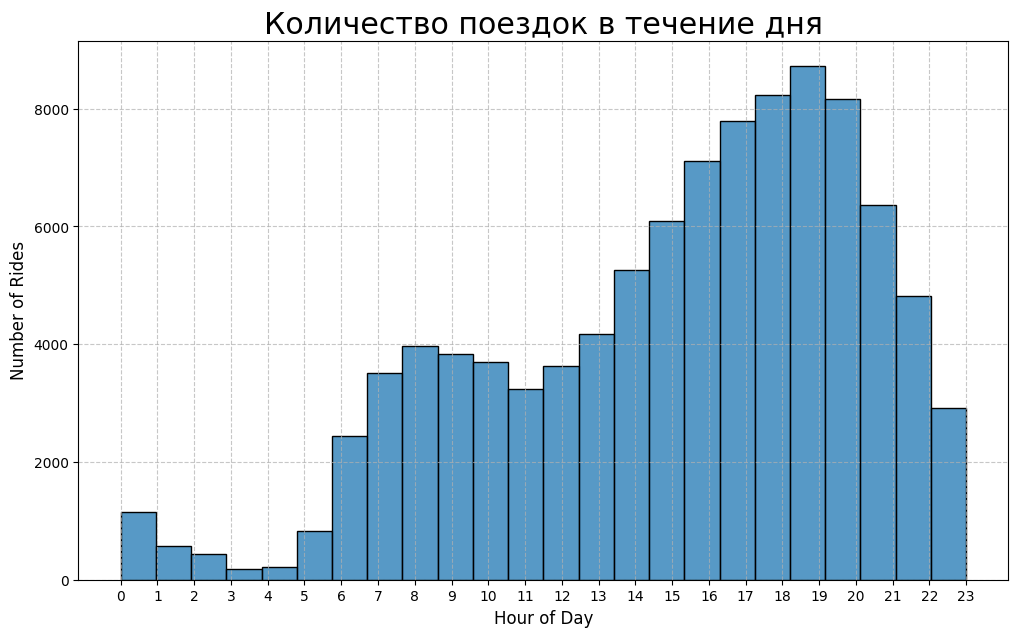

In [386]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour

plt.figure(figsize=(12, 7))
sns.histplot(df_rides["start_hour"], bins=24, kde=False)
plt.title("Количество поездок в течение дня")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Rides")
plt.xticks(range(0, 24))
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

df_rides = df_rides.drop("start_hour", axis=1)

Исходя из графика мы видим 3 разных 'бугорка' с 23:00 до 6:00; c 7:00 до 13:00; c 14 до 22

In [387]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour
conditions = [
    (df_rides["start_hour"] >= 23) | (df_rides["start_hour"] <= 6),
    (df_rides["start_hour"] >= 7) & (df_rides["start_hour"] <= 13),
    (df_rides["start_hour"] >= 14) & (df_rides["start_hour"] <= 22),
]
choices = ["ночь", "утро", "день"]
df_rides["period_of_time"] = np.select(conditions, choices, default="unknown")
df_rides = df_rides.drop("start_hour", axis=1)

df_rides.head()

start_date            end_date start_location   start_district  \
0 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3 2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   

  end_location     end_district  distance  promo   duration   avg_speed  \
0      майская      октябрьский    4069.0  False  23.700000  171.687764   
1   спортивная      октябрьский    4515.0  False  28.416667  158.885630   
2     суворова        ленинский    4520.0  False  38.316667  117.964332   
3      рабочая  северо-западный    3881.0  False  31.816667  121.980094   
4    юбилейная    юго-восточный    4029.0  False  30.666667  131.380435   

   group_of_time  day_of_week period_of_time  
0              2            6           утро  
1              2            6           утро  
2              2            6           утро  
3              2            6           утро  
4              2            6           утро

### Расчёт цены поездки

Рассчитаем цену с учётом акции

In [388]:
df_rides["cost_per_minute"] = df_rides.apply(calculate_cost_per_minute, axis=1)
df_rides["base_cost"] = df_rides["promo"].apply(lambda x: 0 if x else 30)
df_rides["cost"] = df_rides["base_cost"] + (
    df_rides["duration"] * df_rides["cost_per_minute"]
)

df_rides = df_rides.drop(columns=["cost_per_minute", "base_cost"])

#### Найдём прирост активности от акции

Для этого найдём наиболее "похожий" на понедельник день и сравним среднее количество поездок в период проведения акции (с 6:00 до 10:00) и в "похожий день" без акции (в этот же период времени)

**Для нахождения "похожего" на понедельник дня:**

Берём время в понедельник, не принадлежащее акции (наример с 10:00 до 16:00). И сравниваем статистики в других днях недели для этого же времени.

Посмотрим на самый похожий день

In [389]:
# дата сеты с записями по разным дням недели не включающие время проведения акции
for day in range(1, 8):
    globals()[f"df_day{day}"] = df_rides[
        (df_rides["day_of_week"] == day) & (df_rides["group_of_time"] != 2)
    ]

In [390]:
day_dataframes = {
    "df_day1": df_day1,
    "df_day2": df_day2,
    "df_day3": df_day3,
    "df_day4": df_day4,
    "df_day5": df_day5,
    "df_day6": df_day6,
    "df_day7": df_day7,
}
most_similar_day1, similarity_score1 = find_most_similar_day(day_dataframes)
print(
    f"Самый похожий день: {most_similar_day1} с коэффициентом 'схожести' {similarity_score1:.4f}"
)

Самый похожий день: df_day2 с коэффициентом 'схожести' 1.9911


На основе анализа был выявлен самый похожий день: вторник с коэффициентом 'схожести' 1.9911

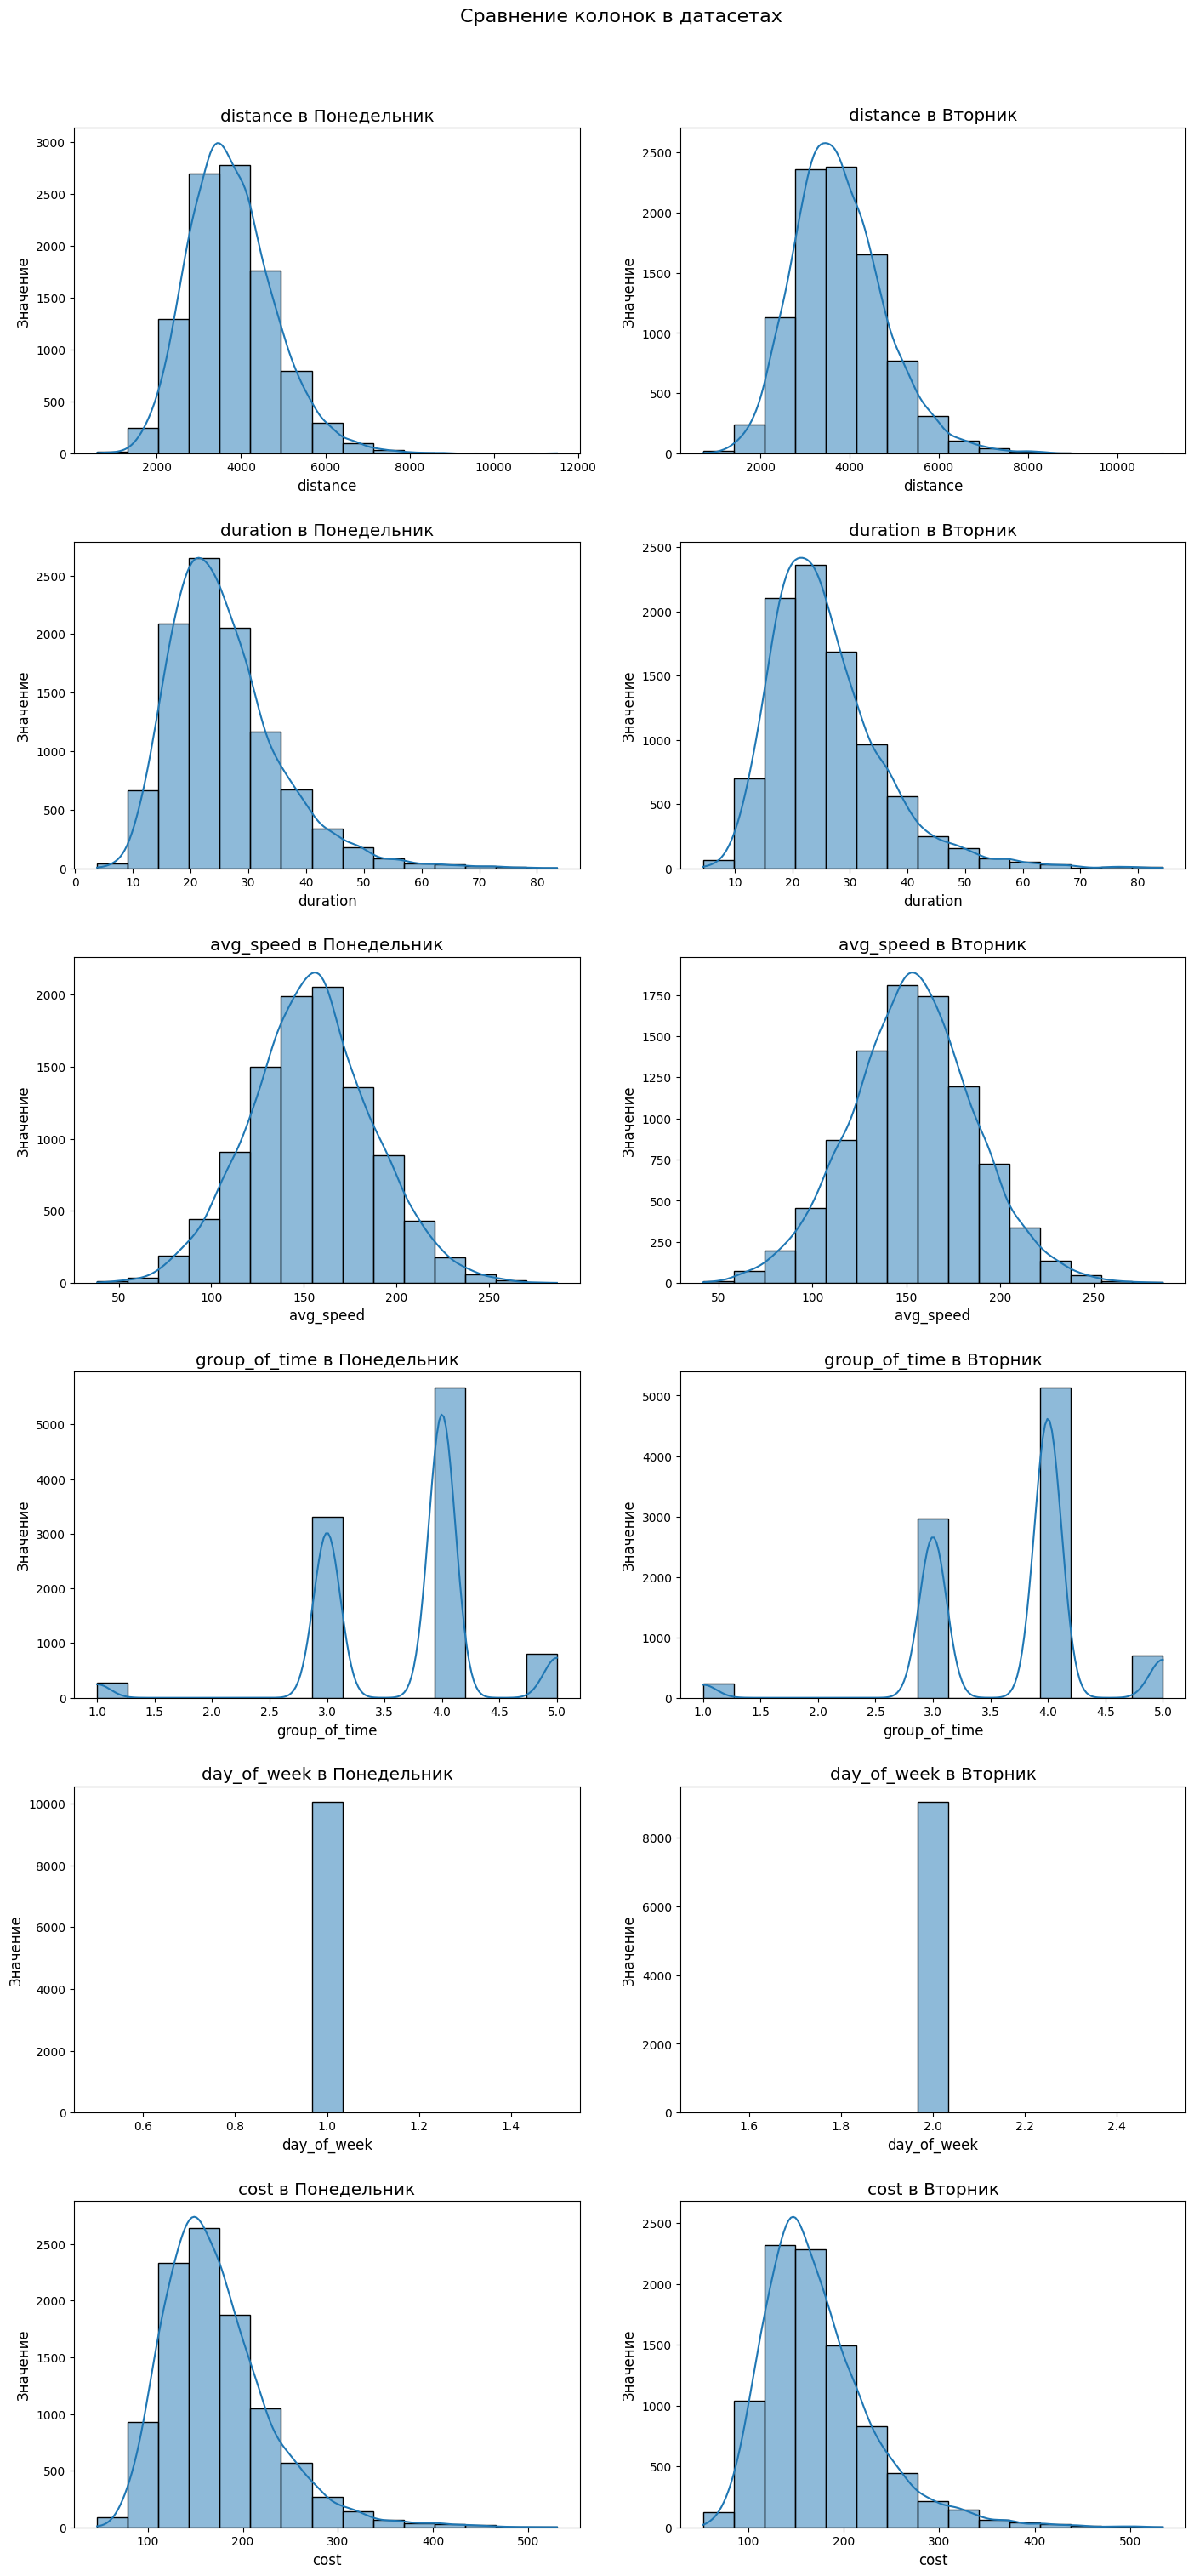

In [391]:
plot_comparison_histograms(
    df_day1,
    df_day2,
    integer_data(df_day1),
    df1_title="Понедельник",
    df2_title="Вторник",
)

Исходя из аналитического и графического анализа делаем вывод, что вторник имеет наиболее похожие статистики на понедельник, в период не проведения акции.
Следовательно для дальнейшего сравнения с дата сетом с акцией мы будем использовать вторник в этот же период времени.

In [392]:
df_promotion = df_rides[
    (df_rides["day_of_week"] == 1) & (df_rides["group_of_time"] == 2)
]
df_not_promotion = df_rides[
    (df_rides["day_of_week"] == 2) & (df_rides["group_of_time"] == 2)
]

Теперь мы можем определиить окупаемость акции и увеличение спроса, сравнив прибыль и спрос в период проведения акции с этим же периодом врмени во вторник

In [393]:
profit_in_monday = df_promotion["cost"].sum()
profit_in_tuesday = df_not_promotion["cost"].sum()

rides_promotion = df_promotion.shape[0]
avg_distance_promotion = df_promotion["distance"].mean()
avg_duration_promotion = df_promotion["duration"].mean()

rides_not_promotion = df_not_promotion.shape[0]
avg_distance_not_promotion = df_not_promotion["distance"].mean()
avg_duration_not_promotion = df_not_promotion["duration"].mean()

avg_profit_promotion = profit_in_monday / rides_promotion
avg_profit_not_promotion = profit_in_tuesday / rides_not_promotion

print("--- Период акции (Понедельник, 06:00-10:00) ---")
print(f"Прибыль: {profit_in_monday:.2f}")
print(f"Количество поездок: {rides_promotion}")
print(f"Средняя дистанция поездки: {avg_distance_promotion:.2f}")
print(f"Средняя продолжительсноть поездки: {avg_duration_promotion:.2f}")
print(f"Средняя прибыль за поездку: {avg_profit_promotion:.2f}")

print("\n--- Период в которыйй акция не проводится (Вторник, 06:00-10:00) ---")
print(f"Прибыль: {profit_in_tuesday:.2f}")
print(f"Количество поездок: {rides_not_promotion}")
print(f"Средняя дистанция поездки: {avg_distance_not_promotion:.2f}")
print(f"Средняя продолжительсноть поездки: {avg_duration_not_promotion:.2f}")
print(f"Средняя прибыль за поездку: {avg_profit_not_promotion:.2f}")

--- Период акции (Понедельник, 06:00-10:00) ---
Прибыль: 287588.11
Количество поездок: 2675
Средняя дистанция поездки: 3782.61
Средняя продолжительсноть поездки: 24.74
Средняя прибыль за поездку: 107.51

--- Период в которыйй акция не проводится (Вторник, 06:00-10:00) ---
Прибыль: 276373.89
Количество поездок: 2152
Средняя дистанция поездки: 3798.04
Средняя продолжительсноть поездки: 24.61
Средняя прибыль за поездку: 128.43


*Уменьшение средней прибыли за поездку обуславливается уменьшением её цены на 30 рублей*

### Выводы по задаче

Исходя из приведённых выше статистик мы можем сделать вывод:


*   Акция стимулирует спрос на самокаты (так как значительно увеличилось количество поездок)
*   Акция окупает себя (Прибыль за период проведения акции выше, чем в период не проведения акции при других примерно равных сатистиках)



### Таблица с почасовым трафиком в каждой точке

Создадим таблицу для сравнения трафика в разных точках

In [394]:
df_rides["start_hour"] = df_rides["start_date"].dt.hour

df_rides_hourly_traffic_by_hour = (
    df_rides.groupby(["start_hour", "start_location"])
    .size()
    .unstack(level="start_location")
    .fillna(0)
)

In [395]:
df_rides_hourly_traffic_final = df_rides_hourly_traffic_by_hour.T
df_rides_hourly_traffic_final.head(5)

start_hour        0     1    2    3    4     5     6     7      8     9   ...  \
start_location                                                            ...   
береговая       11.0   7.0  4.0  2.0  4.0   2.0  16.0  21.0   25.0  34.0  ...   
березовая       12.0   5.0  6.0  5.0  0.0  13.0  35.0  50.0   53.0  48.0  ...   
буденного       28.0  13.0  5.0  5.0  4.0  20.0  77.0  83.0  116.0  99.0  ...   
вишневая         7.0   3.0  1.0  1.0  3.0   9.0  14.0  26.0   46.0  32.0  ...   
вокзальная      13.0   3.0  2.0  1.0  1.0  10.0  16.0  33.0   39.0  26.0  ...   

start_hour         14     15     16     17     18     19     20     21    22  \
start_location                                                                 
береговая        50.0   45.0   60.0   68.0   86.0   92.0   81.0   65.0  58.0   
березовая        53.0   71.0   90.0  108.0   87.0  115.0  107.0   71.0  57.0   
буденного       124.0  129.0  153.0  170.0  183.0  167.0  171.0  130.0  94.0   
вишневая         45.0   58.0   79.0   68.0   44.0   72.0   68.0   60.0  33.0   
вокзальная       56.0   55.0   53.0   70.0   71.0   87.0   57.0   60.0  31.0   

start_hour        23  
start_location        
береговая       35.0  
березовая       31.0  
буденного       57.0  
вишневая        21.0  
вокзальная      23.0  

[5 rows x 24 columns]

In [396]:
df_rides_hourly_traffic_final["total_count_rides"] = df_rides_hourly_traffic_final.sum(
    axis=1
)

In [397]:
sum_total_rides = df_rides_hourly_traffic_final["total_count_rides"].sum().astype(int)

**Суммарное количество поездок за всё время 97354**

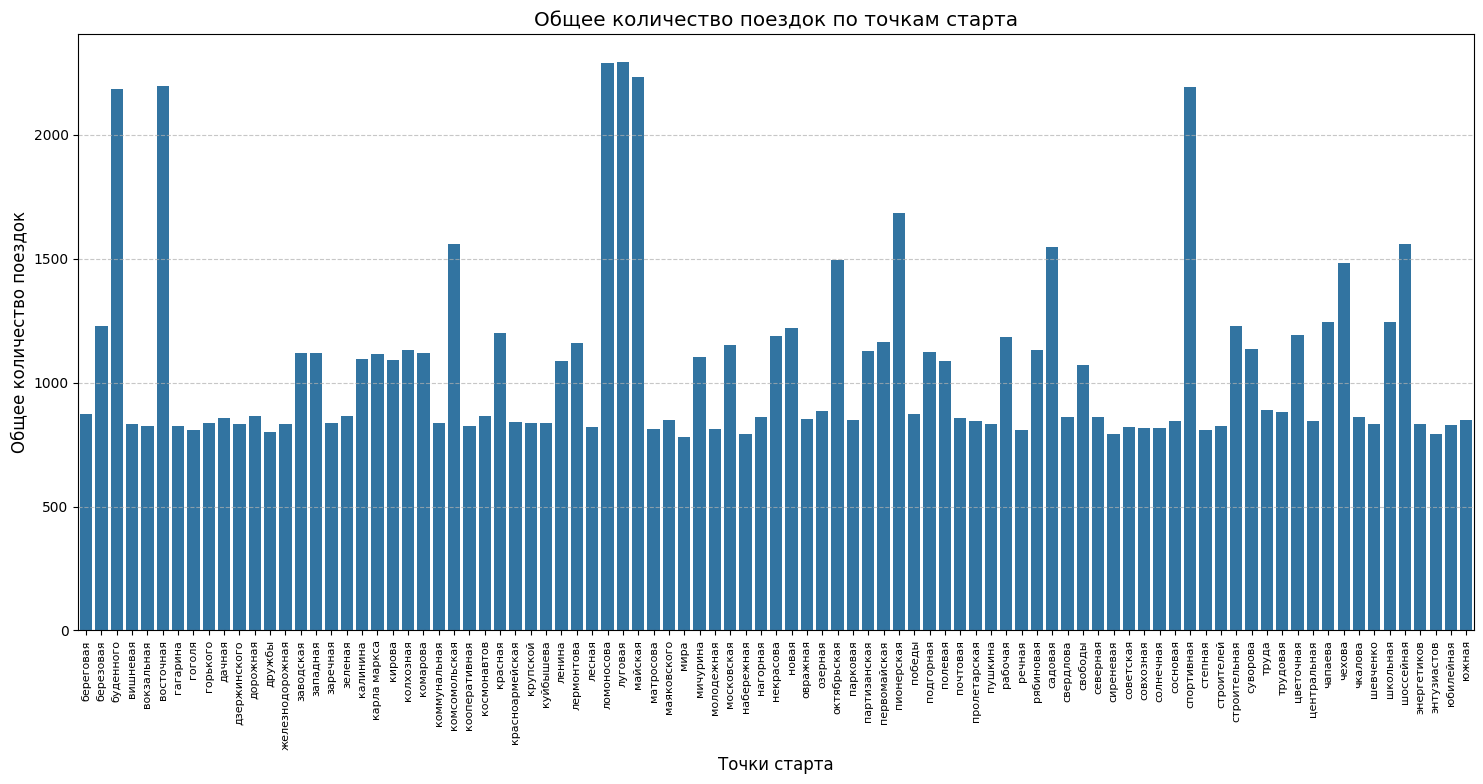

In [398]:
plt.figure(figsize=(15, 8))
sns.barplot(
    x=df_rides_hourly_traffic_final.index,
    y="total_count_rides",
    data=df_rides_hourly_traffic_final,
)
plt.title("Общее количество поездок по точкам старта")
plt.xlabel("Точки старта")
plt.ylabel("Общее количество поездок")
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

Определим топ 3 точки с самым высоким трафиком.

In [399]:
top_3_locations = df_rides_hourly_traffic_final.sort_values(
    by="total_count_rides", ascending=False
).head(3)
top_3_locations

start_hour         0     1     2    3    4     5     6     7      8     9  \
start_location                                                              
луговая         25.0  15.0   9.0  6.0  4.0  22.0  48.0  86.0   80.0  99.0   
ломоносова      28.0  12.0  18.0  2.0  4.0  22.0  63.0  88.0   93.0  92.0   
майская         28.0  19.0   5.0  4.0  6.0  20.0  57.0  79.0  103.0  98.0   

start_hour      ...     15     16     17     18     19     20     21     22  \
start_location  ...                                                           
луговая         ...  120.0  187.0  172.0  188.0  219.0  186.0  141.0  111.0   
ломоносова      ...  146.0  175.0  195.0  186.0  184.0  199.0  142.0  108.0   
майская         ...  145.0  166.0  181.0  175.0  214.0  173.0  128.0  104.0   

start_hour        23  total_count_rides  
start_location                           
луговая         60.0             2293.0  
ломоносова      56.0             2292.0  
майская         64.0             2235.0  

[3 rows x 25 columns]

#### В ходе анализа выяснилось, что топ - 3 точки по трафику это:


*   **Луговая**
*   **Ломоносова**
*   **Майская**

#### Определим худшие точки по трафику, которые потенциально можно будет закрыть.

In [400]:
top_of_tails_locations = df_rides_hourly_traffic_final.sort_values(
    by="total_count_rides", ascending=True
)
top_of_tails_locations

start_hour         0     1     2    3    4     5     6     7      8     9  \
start_location                                                              
мира            13.0   6.0   7.0  0.0  4.0   7.0  18.0  19.0   21.0  21.0   
набережная       8.0   8.0   3.0  1.0  4.0   4.0  13.0  20.0   20.0  23.0   
энтузиастов      9.0   9.0   2.0  0.0  1.0   7.0  13.0  23.0   29.0  28.0   
сиреневая        5.0   7.0   5.0  1.0  0.0   4.0  28.0  20.0   29.0  42.0   
дружбы          20.0   3.0   3.0  3.0  6.0   6.0  12.0  19.0   20.0  22.0   
...              ...   ...   ...  ...  ...   ...   ...   ...    ...   ...   
спортивная      28.0  11.0  11.0  2.0  5.0  13.0  68.0  99.0  104.0  91.0   
восточная       29.0  10.0  13.0  2.0  8.0  19.0  71.0  73.0  100.0  89.0   
майская         28.0  19.0   5.0  4.0  6.0  20.0  57.0  79.0  103.0  98.0   
ломоносова      28.0  12.0  18.0  2.0  4.0  22.0  63.0  88.0   93.0  92.0   
луговая         25.0  15.0   9.0  6.0  4.0  22.0  48.0  86.0   80.0  99.0   

start_hour      ...     15     16     17     18     19     20     21     22  \
start_location  ...                                                           
мира            ...   66.0   52.0   61.0   75.0   69.0   78.0   60.0   34.0   
набережная      ...   62.0   59.0   71.0   74.0   74.0   87.0   60.0   45.0   
энтузиастов     ...   46.0   73.0   59.0   86.0   75.0   79.0   42.0   46.0   
сиреневая       ...   54.0   63.0   62.0   77.0   60.0   63.0   44.0   42.0   
дружбы          ...   49.0   55.0   49.0   83.0   71.0   79.0   77.0   60.0   
...             ...    ...    ...    ...    ...    ...    ...    ...    ...   
спортивная      ...  118.0  145.0  165.0  176.0  185.0  175.0  142.0   96.0   
восточная       ...  128.0  159.0  183.0  180.0  180.0  170.0  115.0  108.0   
майская         ...  145.0  166.0  181.0  175.0  214.0  173.0  128.0  104.0   
ломоносова      ...  146.0  175.0  195.0  186.0  184.0  199.0  142.0  108.0   
луговая         ...  120.0  187.0  172.0  188.0  219.0  186.0  141.0  111.0   

start_hour        23  total_count_rides  
start_location                           
мира            22.0              779.0  
набережная      32.0              793.0  
энтузиастов     21.0              794.0  
сиреневая       22.0              795.0  
дружбы          21.0              800.0  
...              ...                ...  
спортивная      74.0             2192.0  
восточная       72.0             2197.0  
майская         64.0             2235.0  
ломоносова      56.0             2292.0  
луговая         60.0             2293.0  

[91 rows x 25 columns]

Для этого посмотрим на количество точек в районе и их прибыль. Если в этом районе есть много точек с сильно различающейся прибылью, это станет поводом для рассмотрения возможности закрытия этих точек

In [401]:
df_location_district = df_rides[["start_location", "start_district"]].drop_duplicates()
top_of_tails_locations_reset = top_of_tails_locations.reset_index()
top_of_tails_locations_with_district = pd.merge(
    top_of_tails_locations_reset, df_location_district, on="start_location", how="left"
)
top_of_tails_locations_with_district

start_location     0     1     2    3    4     5     6     7      8  ...  \
0            мира  13.0   6.0   7.0  0.0  4.0   7.0  18.0  19.0   21.0  ...   
1      набережная   8.0   8.0   3.0  1.0  4.0   4.0  13.0  20.0   20.0  ...   
2     энтузиастов   9.0   9.0   2.0  0.0  1.0   7.0  13.0  23.0   29.0  ...   
3       сиреневая   5.0   7.0   5.0  1.0  0.0   4.0  28.0  20.0   29.0  ...   
4          дружбы  20.0   3.0   3.0  3.0  6.0   6.0  12.0  19.0   20.0  ...   
..            ...   ...   ...   ...  ...  ...   ...   ...   ...    ...  ...   
86     спортивная  28.0  11.0  11.0  2.0  5.0  13.0  68.0  99.0  104.0  ...   
87      восточная  29.0  10.0  13.0  2.0  8.0  19.0  71.0  73.0  100.0  ...   
88        майская  28.0  19.0   5.0  4.0  6.0  20.0  57.0  79.0  103.0  ...   
89     ломоносова  28.0  12.0  18.0  2.0  4.0  22.0  63.0  88.0   93.0  ...   
90        луговая  25.0  15.0   9.0  6.0  4.0  22.0  48.0  86.0   80.0  ...   

       16     17     18     19     20     21     22    23  total_count_rides  \
0    52.0   61.0   75.0   69.0   78.0   60.0   34.0  22.0              779.0   
1    59.0   71.0   74.0   74.0   87.0   60.0   45.0  32.0              793.0   
2    73.0   59.0   86.0   75.0   79.0   42.0   46.0  21.0              794.0   
3    63.0   62.0   77.0   60.0   63.0   44.0   42.0  22.0              795.0   
4    55.0   49.0   83.0   71.0   79.0   77.0   60.0  21.0              800.0   
..    ...    ...    ...    ...    ...    ...    ...   ...                ...   
86  145.0  165.0  176.0  185.0  175.0  142.0   96.0  74.0             2192.0   
87  159.0  183.0  180.0  180.0  170.0  115.0  108.0  72.0             2197.0   
88  166.0  181.0  175.0  214.0  173.0  128.0  104.0  64.0             2235.0   
89  175.0  195.0  186.0  184.0  199.0  142.0  108.0  56.0             2292.0   
90  187.0  172.0  188.0  219.0  186.0  141.0  111.0  60.0             2293.0   

    start_district  
0      центральный  
1      центральный  
2      центральный  
3    юго-восточный  
4      центральный  
..             ...  
86     октябрьский  
87     октябрьский  
88     октябрьский  
89     октябрьский  
90     октябрьский  

[91 rows x 27 columns]

In [402]:
top_of_tails_locations_with_district_counts = (
    top_of_tails_locations_with_district.groupby("start_district")
    .size()
    .reset_index(name="count_of_worst_locations")
)
top_of_tails_locations_with_district_counts

start_district  count_of_worst_locations
0         заречный                         6
1        ленинский                        14
2      октябрьский                         6
3  северо-западный                        13
4      центральный                        30
5    юго-восточный                        22

Добавим в таблицу прибыль от точки, для более детального анализа

In [403]:
df_profit_per_location = df_rides.groupby("start_location")["cost"].sum().reset_index()
df_profit_per_location.columns = ["start_location", "total_profit"]
top_of_tails_locations_with_profit = pd.merge(
    top_of_tails_locations_with_district,
    df_profit_per_location,
    on="start_location",
    how="left",
)

Посмотрим на худшие 10 точек по трафику и их прибыль

In [404]:
top_10_of_tails_locations_with_profit = top_of_tails_locations_with_profit.head(10)[
    ["start_location", "start_district", "total_count_rides", "total_profit"]
]
print(top_10_of_tails_locations_with_profit)

  start_location start_district  total_count_rides   total_profit
0           мира    центральный              779.0  134055.737359
1     набережная    центральный              793.0  136331.035109
2    энтузиастов    центральный              794.0  138424.140615
3      сиреневая  юго-восточный              795.0  146688.648258
4         дружбы    центральный              800.0  140926.032550
5         гоголя    центральный              808.0  137541.857058
6         речная  юго-восточный              810.0  143098.927125
7        степная    центральный              811.0  140356.981970
8      матросова    центральный              812.0  140034.734776
9     молодежная  юго-восточный              815.0  146454.443242


In [405]:
top_of_tails_locations_with_district_counts1 = (
    top_10_of_tails_locations_with_profit.groupby("start_district")
    .size()
    .reset_index(name="count_of_worst_locations")
)

In [406]:
print("Количество худших точек в разных районах")
print(top_of_tails_locations_with_district_counts1)

Количество худших точек в разных районах
  start_district  count_of_worst_locations
0    центральный                         7
1  юго-восточный                         3


#### Вывод по анализу точек с самым маленьким трафиком

> Большинство точек с самым маленьким трафиком
находятся в районе "Центральный" и "Юго-восточный", но при этом эти же районы имеют самое большое количество точек

Из этого можно сделать вывод о том, что есть повод для дальнейшего анализа причин такого поведения, а так же рассмотрения возможности закрытия некоторых точек из приведённого выше списка

#### Самые популярные направления перемещения

In [407]:
df_rides["destinations"] = (
    df_rides["start_location"] + " -> " + df_rides["end_location"]
)
df_rides.head()

start_date            end_date start_location   start_district  \
0 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3 2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   

  end_location     end_district  distance  promo   duration   avg_speed  \
0      майская      октябрьский    4069.0  False  23.700000  171.687764   
1   спортивная      октябрьский    4515.0  False  28.416667  158.885630   
2     суворова        ленинский    4520.0  False  38.316667  117.964332   
3      рабочая  северо-западный    3881.0  False  31.816667  121.980094   
4    юбилейная    юго-восточный    4029.0  False  30.666667  131.380435   

   group_of_time  day_of_week period_of_time        cost  start_hour  \
0              2            6           утро  124.800000           9   
1              2            6           утро  143.666667           9   
2              2            6           утро  183.266667           9   
3              2            6           утро  157.266667           9   
4              2            6           утро  152.666667           9   

                destinations  
0        шевченко -> майская  
1       чехова -> спортивная  
2      буденного -> суворова  
3           труда -> рабочая  
4  первомайская -> юбилейная

In [408]:
df_destinations_traffic = (
    df_rides.groupby("destinations").size().reset_index(name="ride_count")
)
df_destinations_traffic.head()

destinations  ride_count
0   береговая -> береговая           6
1   береговая -> березовая           8
2   береговая -> буденного          19
3    береговая -> вишневая           8
4  береговая -> вокзальная          10

Посомтрим на самые популярыне направления пекремещения

In [409]:
popular_travel_destinations = df_destinations_traffic.sort_values(
    by="ride_count", ascending=False
)
popular_travel_destinations.head()

destinations  ride_count
184    буденного -> буденного          68
3256    луговая -> спортивная          67
3347    майская -> спортивная          61
6586    спортивная -> майская          60
489   восточная -> ломоносова          59

Их приведённого выше дата сета можно седалть следующие выводы:

1.   Есть направления перемещения в которых
начинаются и заканчиваются в одной точке.
2.   Точка "Спортивная" является популярной конечной точкой.
3.   "майская -> спортивная" и "спортивная -> майская" являются взаимнообратными и популярными, что говорит о каких то важных объектах в области близкой к этим точкам(Это может помочь в дальнейшем анализе аудитории нашего сервиса и распределении количества самокатов).
4.   В популярных направлениях присутствуют точки с самым популярным трафиком, что подтверждает правильность их определения.

##### Рассмотрим необходимость перераспределения самокотов по точкам в конце дня

In [410]:
df_rides_redistribution = df_rides.copy()

In [411]:
# Оставляем только значение даты
df_rides_redistribution["start_date_day"] = df_rides_redistribution[
    "start_date"
].dt.date
df_rides_redistribution["end_date_day"] = df_rides_redistribution["end_date"].dt.date

scooters_started = (
    df_rides_redistribution.groupby(["start_date_day", "start_location"])
    .size()
    .unstack(fill_value=0)
)
scooters_ended = (
    df_rides_redistribution.groupby(["end_date_day", "end_location"])
    .size()
    .unstack(fill_value=0)
)

all_dates = sorted(list(set(scooters_started.index) | set(scooters_ended.index)))
all_locations = sorted(
    list(set(scooters_started.columns) | set(scooters_ended.columns))
)

daily_net_change_by_location = pd.DataFrame(0, index=all_dates, columns=all_locations)

for date in all_dates:
    if date in scooters_started.index:
        daily_net_change_by_location.loc[
            date, scooters_started.loc[date].index
        ] -= scooters_started.loc[date]
    if date in scooters_ended.index:
        daily_net_change_by_location.loc[
            date, scooters_ended.loc[date].index
        ] += scooters_ended.loc[date]

daily_net_change = daily_net_change_by_location.mean().sort_values(ascending=False)

print("Среднее ежедневное изменение количества самокатов по точкам:")
print(daily_net_change.head())
print(daily_net_change.tail())

Среднее ежедневное изменение количества самокатов по точкам:
спортивная    1.186275
буденного     0.931373
восточная     0.872549
ленина        0.784314
матросова     0.764706
dtype: float64
дачная       -0.715686
нагорная     -0.715686
труда        -0.764706
пушкина      -1.215686
пионерская   -1.911765
dtype: float64


##### Анализ результатов по перераспределению самокатов

**Топ-5 точек с наибольшим профицитом самокатов (накопление):**

- Спортивная: 1.19
- Буденного: 0.93
- Восточная: 0.87
- Ленина: 0.78
- Матросова: 0.76

**Топ-5 точек с наибольшим дефицитом самокатов (нехватка):**

- Дачная: -0.72
- Нагорная: -0.72
- Труда: -0.76
- Пушкина: -1.22
- Пионерская: -1.91

##### Найдём изменение в точках в абсолютных значениях

In [412]:
df_rides_redistribution["end_hour"] = df_rides_redistribution["end_date"].dt.hour
df_rides_redistribution.head()

start_date            end_date start_location   start_district  \
0 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3 2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   

  end_location     end_district  distance  promo   duration   avg_speed  \
0      майская      октябрьский    4069.0  False  23.700000  171.687764   
1   спортивная      октябрьский    4515.0  False  28.416667  158.885630   
2     суворова        ленинский    4520.0  False  38.316667  117.964332   
3      рабочая  северо-западный    3881.0  False  31.816667  121.980094   
4    юбилейная    юго-восточный    4029.0  False  30.666667  131.380435   

   group_of_time  day_of_week period_of_time        cost  start_hour  \
0              2            6           утро  124.800000           9   
1              2            6           утро  143.666667           9   
2              2            6           утро  183.266667           9   
3              2            6           утро  157.266667           9   
4              2            6           утро  152.666667           9   

                destinations start_date_day end_date_day  end_hour  
0        шевченко -> майская     2023-04-22   2023-04-22         9  
1       чехова -> спортивная     2023-04-22   2023-04-22         9  
2      буденного -> суворова     2023-04-22   2023-04-22         9  
3           труда -> рабочая     2023-04-22   2023-04-22         9  
4  первомайская -> юбилейная     2023-04-22   2023-04-22         9

In [413]:
df_rides_redistribution["start_hour"] = df_rides_redistribution["start_date"].dt.hour

hourly_scooters_started = (
    df_rides_redistribution.groupby(["start_hour", "start_location"])
    .size()
    .unstack(fill_value=0)
)
hourly_scooters_ended = (
    df_rides_redistribution.groupby(["end_hour", "end_location"])
    .size()
    .unstack(fill_value=0)
)

print("Самокатов в начале каждого часа(первые 5 часов и 5 локаций):")
print(hourly_scooters_started.iloc[:5, :5])
print("\nСамокатов в конце каждого часа(первые 5 часов и 5 локаций):")
print(hourly_scooters_ended.iloc[:5, :5])

Самокатов в начале каждого часа(первые 5 часов и 5 локаций):
start_location  береговая  березовая  буденного  вишневая  вокзальная
start_hour                                                           
0                      11         12         28         7          13
1                       7          5         13         3           3
2                       4          6          5         1           2
3                       2          5          5         1           1
4                       4          0          4         3           1

Самокатов в конце каждого часа(первые 5 часов и 5 локаций):
end_location  береговая  березовая  буденного  вишневая  вокзальная
end_hour                                                           
0                    18         28         48        11          20
1                     5         12         31         5           5
2                     1          4         16         3           3
3                     1          8         14   

In [414]:
hourly_net_change = hourly_scooters_ended.sub(hourly_scooters_started, fill_value=0)

print(
    "Изменения количества самокатов в абсолютных значениях по часам (первые 5 часов и 5 районов):"
)
print(hourly_net_change.iloc[:5, :5])
print(
    "\nИзменения количества самокатов в абсолютных значениях по часам (последние 5 часов и 5 районов):"
)
print(hourly_net_change.iloc[-5:, -5:])

Изменения количества самокатов в абсолютных значениях по часам (первые 5 часов и 5 районов):
end_location  береговая  березовая  буденного  вишневая  вокзальная
end_hour                                                           
0                     7         16         20         4           7
1                    -2          7         18         2           2
2                    -3         -2         11         2           1
3                    -1          3          9         2           2
4                     0          1          3         0           2

Изменения количества самокатов в абсолютных значениях по часам (последние 5 часов и 5 районов):
end_location  шоссейная  энергетиков  энтузиастов  юбилейная  южная
end_hour                                                           
19                   21            2          -12         -5    -33
20                   30            0          -27         11    -15
21                   48            0           10         20  

In [415]:
end_of_day_net_change = hourly_net_change.loc[23].sort_values(ascending=False)

print("Точки с самым большим префицитом самокатов на 24:00:")
print(end_of_day_net_change.head(5))

print("\nТочки с самым большим дефицитом самокатов на 24:00:")
print(end_of_day_net_change.tail(5))

Точки с самым большим префицитом самокатов на 24:00:
end_location
октябрьская      36
красная          31
восточная        30
комсомольская    29
садовая          27
Name: 23, dtype: int64

Точки с самым большим дефицитом самокатов на 24:00:
end_location
береговая   -10
овражная    -11
степная     -12
советская   -13
пушкина     -13
Name: 23, dtype: int64


#### Выводы по перераспределению самокатов

* В число точек с самым высоким среднесуточным профицитом вошли:
1.   **Спортивная (+1,19)**
2.   **Буденного (+0,93)**
* В число точек с самым высоким среднесуточным дефицитом вошли:
1.   **Пионерская (-1,91)**
2.   **Пушкина (-1,22)**


* Анализ распределения самскатов по состоянию на 24:00 выявил:
    * В топ-5 населенных пунктов с наибольшим профицитом на 24:00 вошли:

1.   **Октябрьская (36)**
2.   **Красная (31)**
3.   **Восточная (30)**
4.   **Комсомольская (29)**
5.   **Сада (27)**
     * В топ-5 населенных пунктов с наибольшим дефицитом на 24:00 вошли :

1. **Пушкина (-13)**
2.   **Совецкая (-13)**
3.   **Степная (-12)**
4.   **Охранная (-11)**
5.   **Береговая (-10)**

#### Определим необходимое количество самокатов в каждой точке и в каждом районе для удовлетворения спроса.

(предполагаем что ежедневно в 06:00 самокаты будут перераспределяются к исходной поизиции)

**Добавляем столбец 'day_number' для более удобной агрегации**

In [416]:
df_rides_redistribution["scooter_day_start"] = df_rides_redistribution[
    "start_date"
].apply(
    lambda x: (
        (x.normalize() - pd.Timedelta(days=1)).replace(hour=6, minute=0, second=0)
        if x.hour < 6
        else x.normalize().replace(hour=6, minute=0, second=0)
    )
)
df_rides_redistribution = df_rides_redistribution.sort_values(by="scooter_day_start")
df_rides_redistribution["day_number"] = (
    df_rides_redistribution["scooter_day_start"].factorize()[0] + 1
)
df_rides_redistribution.head()

start_date            end_date start_location start_district  \
0   2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко  юго-восточный   
708 2023-04-22 19:56:05 2023-04-22 20:26:24  комсомольская       заречный   
709 2023-04-22 19:56:12 2023-04-22 20:22:36      куйбышева    центральный   
710 2023-04-22 19:56:39 2023-04-22 20:25:46       горького  юго-восточный   
711 2023-04-22 19:56:43 2023-04-22 20:43:21     пионерская       заречный   

    end_location end_district     distance  promo   duration   avg_speed  ...  \
0        майская  октябрьский  4069.000000  False  23.700000  171.687764  ...   
708   строителей  центральный  4070.000000  False  30.316667  134.249588  ...   
709     гагарина  центральный  3833.000000  False  26.400000  145.189394  ...   
710   лермонтова    ленинский  4190.460294  False  29.116667  143.919644  ...   
711     калинина    ленинский  5372.000000  False  46.633333  115.196569  ...   

     day_of_week  period_of_time        cost  start_hour  \
0              6            утро  124.800000           9   
708            6            день  242.216667          19   
709            6            день  214.800000          19   
710            6            день  233.816667          19   
711            6            день  356.433333          19   

                    destinations start_date_day end_date_day end_hour  \
0            шевченко -> майская     2023-04-22   2023-04-22        9   
708  комсомольская -> строителей     2023-04-22   2023-04-22       20   
709        куйбышева -> гагарина     2023-04-22   2023-04-22       20   
710       горького -> лермонтова     2023-04-22   2023-04-22       20   
711       пионерская -> калинина     2023-04-22   2023-04-22       20   

      scooter_day_start day_number  
0   2023-04-22 06:00:00          1  
708 2023-04-22 06:00:00          1  
709 2023-04-22 06:00:00          1  
710 2023-04-22 06:00:00          1  
711 2023-04-22 06:00:00          1  

[5 rows x 21 columns]

In [417]:
# Считаем количество самокатов в начале дня и в конце дня по точкам
scooters_started_daily = df_rides_redistribution.groupby(['day_number', 'start_location']).size().unstack(fill_value=0)
scooters_ended_daily = df_rides_redistribution.groupby(['day_number', 'end_location']).size().unstack(fill_value=0)

# Определяем список всех возможных локаций и дней
all_locations_in_scope = sorted(list(set(scooters_started_daily.columns) | set(scooters_ended_daily.columns)))
all_days_in_scope = sorted(list(set(scooters_started_daily.index) | set(scooters_ended_daily.index)))

In [418]:
# Рассчитываем разность количества самокатов в конце дня и в начале дня
daily_net_change_per_day_location = scooters_ended_daily.sub(
    scooters_started_daily, fill_value=0
)
daily_net_change_per_day_location.head()

end_location  береговая  березовая  буденного  вишневая  вокзальная  \
day_number                                                            
1                     3         -3          2         4          -6   
2                     4         -2          4         2          -2   
3                     1          4         -6        -1           2   
4                    -1          1          4        -3           4   
5                    -1         -5          3        -3           3   

end_location  восточная  гагарина  гоголя  горького  дачная  ...  чапаева  \
day_number                                                   ...            
1                     3        -2       3        -3      -3  ...        9   
2                    -7         1       6         4       3  ...       -4   
3                    -1         2       4        -1       9  ...        4   
4                     1         0      -5        -2      -1  ...        1   
5                     4         0       4         2       6  ...       -4   

end_location  чехова  чкалова  шевченко  школьная  шоссейная  энергетиков  \
day_number                                                                  
1                -10        4        -1         1         -2           -5   
2                  4        6        -5         3          1           -3   
3                  0       -1         2       -10          4           -2   
4                  4       -1         3         3          6            0   
5                  8       -4         2        -1          4           -3   

end_location  энтузиастов  юбилейная  южная  
day_number                                   
1                       5         -1     -3  
2                       7          1      1  
3                      -5          1      3  
4                      -4         -2      0  
5                       6         -3      0  

[5 rows x 91 columns]

In [419]:
# Считаем среднее изменение количества самокатов по точкам
avg_daily_net_change_per_location = daily_net_change_per_day_location.mean()
# Считаем среднее количество самокатов в конце дня по точкам
avg_scooters_ended_per_day_per_location = scooters_ended_daily.mean()

# Расчитываем оптимальное количество самокатов по точкам
optimal_scooters_per_location = (
    (avg_scooters_ended_per_day_per_location - avg_daily_net_change_per_location)
    .fillna(0)
    .round()
    .astype(int)
)

# Создаём дата фрейм для представления результатов
optimal_scooters_df = optimal_scooters_per_location.reset_index()
optimal_scooters_df.columns = ["location", "optimal_scooters"]

location_to_district_map = (
    df_rides.set_index("start_location")["start_district"].to_dict()
)

# Добавляем район в финальный дата фрейм
optimal_scooters_df["district"] = optimal_scooters_df["location"].map(
    location_to_district_map
)

optimal_scooters_by_district = (
    optimal_scooters_df.groupby("district")["optimal_scooters"]
    .sum()
    .sort_values(ascending=False)
)

print("Оптимальное количество самокатов по точкам:")
print(optimal_scooters_df.sort_values(by="optimal_scooters", ascending=False))

print("\nОптимальное количество самокатов по районам:")
print(optimal_scooters_by_district)

Оптимальное количество самокатов по точкам:
       location  optimal_scooters       district
34   ломоносова                23    октябрьский
35      луговая                23    октябрьский
2     буденного                22    октябрьский
72   спортивная                22    октябрьский
36      майская                22    октябрьский
..          ...               ...            ...
84     шевченко                 8  юго-восточный
87  энергетиков                 8  юго-восточный
88  энтузиастов                 8    центральный
89    юбилейная                 8  юго-восточный
90        южная                 8    центральный

[91 rows x 3 columns]

Оптимальное количество самокатов по районам:
district
центральный        247
юго-восточный      181
ленинский          154
северо-западный    153
октябрьский        134
заречный            92
Name: optimal_scooters, dtype: int64


##### Выводы по количеству самокатов в каждой точке

* **Среднесуточное изменение в по точкам**: Среднесуточное изменение значительно варьировалось в зависимости от местоположения. Например, у "береговой" среднедневное чистое изменение составило примерно -0.43, что указывает на небольшой ежедневный дефицит скутеров, в то время как у "буденного" среднедневное чистое изменение составило примерно 0.94, что свидетельствует о небольшом ежедневном избытке.
* **Среднее количество поездок на самокатах в конце дня по точкам**:                   Среднее количество поездок на самокатах в конце дня также варьировалось. На "береговой" в среднем заканчивало около 8.23 самоката в день, на "береговой" - в среднем 12.10, а на "буденного" - в среднем 22.57.
* **Оптимальное количество самокатов в каждой точке**:
Исходя из формулы "среднее количество самокатов в конце дня в точке - среднее ежедневное изменение в точке", в нескольких населенных пунктах требовалось значительное количество самокатов. Лучшие места, включая "Ломоносова", "луговая", "буденного", "спортивная", "майская" и "восточная", показали высокое количество требующихся скутеров - от 22 до 23 в каждом.
* **Оптимальное количество скутеров в каждом районе**:
 Суммирование оптимального количества самокатов по районам показало, что в "центральном" районе было установлено наибольшее количество самокатов - 247. За ним последовали "юго-восточный" со 181 и "ленинский" со 154. В Заречном районе была самая низкая потребность в самокатах - 92 штуки.

### Проверка корреляций


#### выделение дополнительных факторов, которые могут быть полезны, для иследования корреляций

In [420]:
df_weather.set_index("datetime", inplace=True)
df_weather.head()

temperature  precipitation_total  wind_gust  wind_speed  \
datetime                                                                       
2023-04-01 00:00:00     8.740245                  0.1      48.60   21.638964   
2023-04-01 01:00:00     9.040245                  0.2      55.44   22.493519   
2023-04-01 02:00:00     8.880245                  0.3      55.80   22.264770   
2023-04-01 03:00:00     8.690246                  0.3      55.44   21.945240   
2023-04-01 04:00:00     8.630245                  0.3      48.96   22.424270   

                     cloud_cover_total  sunshine_duration  
datetime                                                   
2023-04-01 00:00:00               90.0                0.0  
2023-04-01 01:00:00               74.0                0.0  
2023-04-01 02:00:00               72.0                0.0  
2023-04-01 03:00:00               77.0                0.0  
2023-04-01 04:00:00               78.0                0.0

In [421]:
def get_avg_weather_for_ride(ride_row):
    start_time = ride_row["start_date"].floor("h")
    end_time = ride_row["end_date"].ceil("h")
    weather_during_ride = df_weather.loc[start_time:end_time]
    return weather_during_ride.mean()

In [422]:
ride_weather_data = df_rides.apply(get_avg_weather_for_ride, axis=1)
df_rides_with_weather = pd.concat([df_rides, ride_weather_data], axis=1)
df_rides_with_weather.head(15)

start_date            end_date start_location   start_district  \
0  2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1  2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2  2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3  2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4  2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   
5  2023-04-22 09:10:09 2023-04-22 09:49:56         лесная    юго-восточный   
6  2023-04-22 09:15:12 2023-04-22 09:26:01   пролетарская      центральный   
7  2023-04-22 09:19:13 2023-04-22 09:40:03       комарова        ленинский   
8  2023-04-22 09:21:42 2023-04-22 09:39:04       западная        ленинский   
9  2023-04-22 09:28:00 2023-04-22 10:02:08        свободы        ленинский   
10 2023-04-22 09:37:57 2023-04-22 09:52:42   коммунальная    юго-восточный   
11 2023-04-22 09:39:04 2023-04-22 10:04:52        зеленая      центральный   
12 2023-04-22 09:39:45 2023-04-22 09:52:36      шоссейная         заречный   
13 2023-04-22 09:39:47 2023-04-22 10:19:25    центральная    юго-восточный   
14 2023-04-22 09:43:09 2023-04-22 10:11:25      буденного      октябрьский   

   end_location     end_district     distance  promo   duration   avg_speed  \
0       майская      октябрьский  4069.000000  False  23.700000  171.687764   
1    спортивная      октябрьский  4515.000000  False  28.416667  158.885630   
2      суворова        ленинский  4520.000000  False  38.316667  117.964332   
3       рабочая  северо-западный  3881.000000  False  31.816667  121.980094   
4     юбилейная    юго-восточный  4029.000000  False  30.666667  131.380435   
5      западная        ленинский  4879.000000  False  39.783333  122.639296   
6       свободы        ленинский  1846.000000  False  10.816667  170.662558   
7      западная        ленинский  3133.000000  False  20.833333  150.384000   
8       озерная    юго-восточный  2851.904567  False  17.366667  164.217154   
9       чкалова    юго-восточный  5263.000000  False  34.133333  154.189453   
10   строителей      центральный  2731.000000  False  14.750000  185.152542   
11   спортивная      октябрьский  3391.000000  False  25.800000  131.434109   
12      красная  северо-западный  3354.000000  False  12.850000  261.011673   
13     крупской      центральный  5445.000000  False  39.633333  137.384357   
14     почтовая    юго-восточный  4873.000000  False  28.266667  172.393868   

    ...  period_of_time        cost start_hour                destinations  \
0   ...            утро  124.800000          9         шевченко -> майская   
1   ...            утро  143.666667          9        чехова -> спортивная   
2   ...            утро  183.266667          9       буденного -> суворова   
3   ...            утро  157.266667          9            труда -> рабочая   
4   ...            утро  152.666667          9   первомайская -> юбилейная   
5   ...            утро  189.133333          9          лесная -> западная   
6   ...            утро   73.266667          9     пролетарская -> свободы   
7   ...            утро  113.333333          9        комарова -> западная   
8   ...            утро   99.466667          9         западная -> озерная   
9   ...            утро  166.533333          9          свободы -> чкалова   
10  ...            утро   89.000000          9  коммунальная -> строителей   
11  ...            утро  133.200000          9       зеленая -> спортивная   
12  ...            утро   81.400000          9        шоссейная -> красная   
13  ...            утро  188.533333          9     центральная -> крупской   
14  ...            утро  143.066667          9       буденного -> почтовая   

    temperature precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0     15.040246            0.000000  21.780000    6.015271          79.500000   
1     15.040246            0.000000  21.780000    6.015271          79.500000   
2     

соединяем погоду и поездки в 1 датасет

In [423]:
df_rides_with_weather["start_hour"] = df_rides_with_weather["start_date"].dt.hour
conditions = [
    (df_rides_with_weather["start_hour"] >= 23)
    | (df_rides_with_weather["start_hour"] <= 6),
    (df_rides_with_weather["start_hour"] >= 7)
    & (df_rides_with_weather["start_hour"] <= 13),
    (df_rides_with_weather["start_hour"] >= 14)
    & (df_rides_with_weather["start_hour"] <= 22),
]
choices = ["ночь", "утро", "день"]
df_rides_with_weather["period_of_time"] = np.select(
    conditions, choices, default="unknown"
)
df_rides_with_weather = df_rides_with_weather.drop("start_hour", axis=1)

In [424]:
df_rides_with_weather["start_hour"] = df_rides_with_weather["start_date"].dt.floor("h")
df_rides_with_weather.head()

start_date            end_date start_location   start_district  \
0 2023-04-22 09:01:03 2023-04-22 09:24:45       шевченко    юго-восточный   
1 2023-04-22 09:01:07 2023-04-22 09:29:32         чехова         заречный   
2 2023-04-22 09:04:27 2023-04-22 09:42:46      буденного      октябрьский   
3 2023-04-22 09:06:34 2023-04-22 09:38:23          труда      центральный   
4 2023-04-22 09:09:27 2023-04-22 09:40:07   первомайская  северо-западный   

  end_location     end_district  distance  promo   duration   avg_speed  ...  \
0      майская      октябрьский    4069.0  False  23.700000  171.687764  ...   
1   спортивная      октябрьский    4515.0  False  28.416667  158.885630  ...   
2     суворова        ленинский    4520.0  False  38.316667  117.964332  ...   
3      рабочая  северо-западный    3881.0  False  31.816667  121.980094  ...   
4    юбилейная    юго-восточный    4029.0  False  30.666667  131.380435  ...   

   period_of_time        cost               destinations  temperature  \
0            утро  124.800000        шевченко -> майская    15.040246   
1            утро  143.666667       чехова -> спортивная    15.040246   
2            утро  183.266667      буденного -> суворова    15.040246   
3            утро  157.266667           труда -> рабочая    15.040246   
4            утро  152.666667  первомайская -> юбилейная    15.040246   

  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0                 0.0      21.78    6.015271               79.5   
1                 0.0      21.78    6.015271               79.5   
2                 0.0      21.78    6.015271               79.5   
3                 0.0      21.78    6.015271               79.5   
4                 0.0      21.78    6.015271               79.5   

   sunshine_duration          start_hour  
0          11.818181 2023-04-22 09:00:00  
1          11.818181 2023-04-22 09:00:00  
2          11.818181 2023-04-22 09:00:00  
3          11.818181 2023-04-22 09:00:00  
4          11.818181 2023-04-22 09:00:00  

[5 rows x 22 columns]

In [425]:
df_hourly_data = (
    df_rides_with_weather.groupby("start_hour")
    .agg(
        demand=("start_date", "count"),
        distance=("distance", "mean"),
        duration=("duration", "mean"),
        avg_speed=("avg_speed", "mean"),
        temperature=("temperature", lambda x: x.mode()[0]),
        precipitation_total=("precipitation_total", lambda x: x.mode()[0]),
        wind_gust=("wind_gust", lambda x: x.mode()[0]),
        wind_speed=("wind_speed", lambda x: x.mode()[0]),
        cloud_cover_total=("cloud_cover_total", lambda x: x.mode()[0]),
        sunshine_duration=("sunshine_duration", lambda x: x.mode()[0]),
        promo_proportion=("promo", lambda x: x.mode()[0]),
        period_of_time=("period_of_time", lambda x: x.mode()[0]),
    )
    .reset_index()
)
df_hourly_data.head()

start_hour  demand     distance   duration   avg_speed  \
0 2023-04-22 09:00:00      20  3843.745228  26.528333  152.834451   
1 2023-04-22 10:00:00      42  3610.966916  24.956349  151.479698   
2 2023-04-22 11:00:00      29  3912.119219  26.064943  155.666465   
3 2023-04-22 12:00:00      46  3942.684162  27.094565  152.723147   
4 2023-04-22 13:00:00      47  3792.249365  24.993617  156.174165   

   temperature  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0    15.040246                 0.00  21.780000    6.015271          79.500000   
1    16.655246                 0.05  32.580001    7.257886          91.000000   
2    17.605245                 0.05  35.640000    9.692592          58.100000   
3    18.350245                 0.00  25.080000   15.552307          52.066667   
4    18.460245                 0.00  22.860000   17.985765          67.000000   

   sunshine_duration  promo_proportion period_of_time  
0          11.818181             False           утро  
1           4.848484             False           утро  
2          24.787879             False           утро  
3          28.444443             False           утро  
4          19.393936             False           утро

делаем таблицу для оценки спроса (для каждого часа представлена статистика по спросу и параметрам этого часа)

In [426]:
df_hourly_data["hour_of_day"] = df_hourly_data["start_hour"].dt.hour
df_hourly_data["day_of_week"] = df_hourly_data["start_hour"].dt.dayofweek
df_hourly_data["month"] = df_hourly_data["start_hour"].dt.month
df_hourly_data["is_weekend"] = (df_hourly_data["start_hour"].dt.dayofweek >= 5).astype(
    int
)
df_hourly_data["has_precipitation"] = df_hourly_data["precipitation_total"].apply(
    lambda x: "есть" if x != 0 else "нет"
)
print(df_hourly_data.shape)
df_hourly_data.head()

(2415, 18)


start_hour  demand     distance   duration   avg_speed  \
0 2023-04-22 09:00:00      20  3843.745228  26.528333  152.834451   
1 2023-04-22 10:00:00      42  3610.966916  24.956349  151.479698   
2 2023-04-22 11:00:00      29  3912.119219  26.064943  155.666465   
3 2023-04-22 12:00:00      46  3942.684162  27.094565  152.723147   
4 2023-04-22 13:00:00      47  3792.249365  24.993617  156.174165   

   temperature  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0    15.040246                 0.00  21.780000    6.015271          79.500000   
1    16.655246                 0.05  32.580001    7.257886          91.000000   
2    17.605245                 0.05  35.640000    9.692592          58.100000   
3    18.350245                 0.00  25.080000   15.552307          52.066667   
4    18.460245                 0.00  22.860000   17.985765          67.000000   

   sunshine_duration  promo_proportion period_of_time  hour_of_day  \
0          11.818181             False           утро            9   
1           4.848484             False           утро           10   
2          24.787879             False           утро           11   
3          28.444443             False           утро           12   
4          19.393936             False           утро           13   

   day_of_week  month  is_weekend has_precipitation  
0            5      4           1               нет  
1            5      4           1              есть  
2            5      4           1              есть  
3            5      4           1               нет  
4            5      4           1               нет

категаризируем и упрощаем сложные принзаки

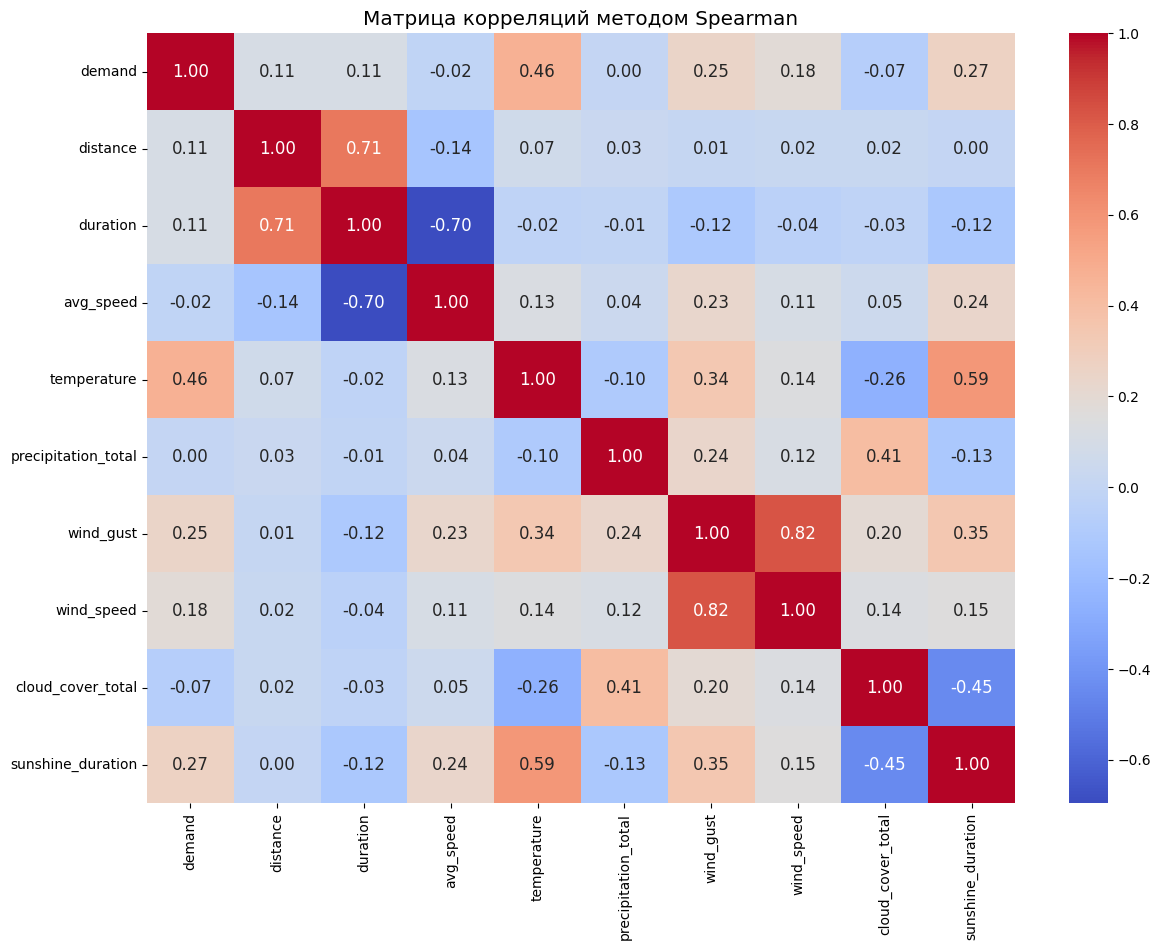

In [427]:
correlation_columns = [
    "demand",
    "distance",
    "duration",
    "avg_speed",
    "temperature",
    "precipitation_total",
    "wind_gust",
    "wind_speed",
    "cloud_cover_total",
    "sunshine_duration",
]
correlation_columns_cat = [
    "hour_of_day",
    "day_of_week",
    "month",
    "is_weekend",
    "promo_proportion",
    "period_of_time",
    "has_precipitation",
]

correlation_matrix = df_hourly_data[correlation_columns].corr(method="spearman")

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Матрица корреляций методом Spearman")
plt.show()

быстрый анализ корреляций количественных стобцов между собой

#### Анализ корреляций спроса и количественными признаков

In [428]:
alph = 0.05

stat_demand, p_value_demand = st.shapiro(df_hourly_data["demand"])

print(f"shapiro-Wilk Test Statistic для 'demand': {stat_demand:.4f}")
print(f"shapiro-Wilk P-value для 'demand': {p_value_demand:.4f}")
print(
    f"Расспределение по 'demand': {'Не нормальное распределение' if p_value_demand < alph else 'Нормальное распределение'}\n"
)

for column in correlation_columns:

    corr_column = df_hourly_data[column]
    stat_current_column, p_value_current_column = st.shapiro(corr_column)

    correlation_method = ""

    if p_value_demand < alph or p_value_current_column < alph:
        correlation_method = "spearman"
    else:
        correlation_method = "pearson"
    value = (
        df_hourly_data[["demand", column]].corr(method=correlation_method).iloc[0, 1]
    )

    print(f"Корреляции с {column}")
    print(
        f"  P-value (demand: {p_value_demand:.4f}, {column}: {p_value_current_column:.4f}). Выбранный метод: '{correlation_method}'."
    )
    print(f"  Значение корреляции ({value:.4f})")

shapiro-Wilk Test Statistic для 'demand': 0.9356
shapiro-Wilk P-value для 'demand': 0.0000
Расспределение по 'demand': Не нормальное распределение

Корреляции с demand
  P-value (demand: 0.0000, demand: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (1.0000)
Корреляции с distance
  P-value (demand: 0.0000, distance: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (0.1125)
Корреляции с duration
  P-value (demand: 0.0000, duration: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (0.1093)
Корреляции с avg_speed
  P-value (demand: 0.0000, avg_speed: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (-0.0166)
Корреляции с temperature
  P-value (demand: 0.0000, temperature: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (0.4650)
Корреляции с precipitation_total
  P-value (demand: 0.0000, precipitation_total: 0.0000). Выбранный метод: 'spearman'.
  Значение корреляции (0.0042)
Корреляции с wind_gust
  P-value (demand: 0.0000, wind_gu

Аналитический подход к проверке корреляций, между спросом и количественными стобцами dataframe'а

По этим данным можно сделать вывод, что спрос сильно зависит от погодных условий

<Figure size 1500x1500 with 0 Axes>

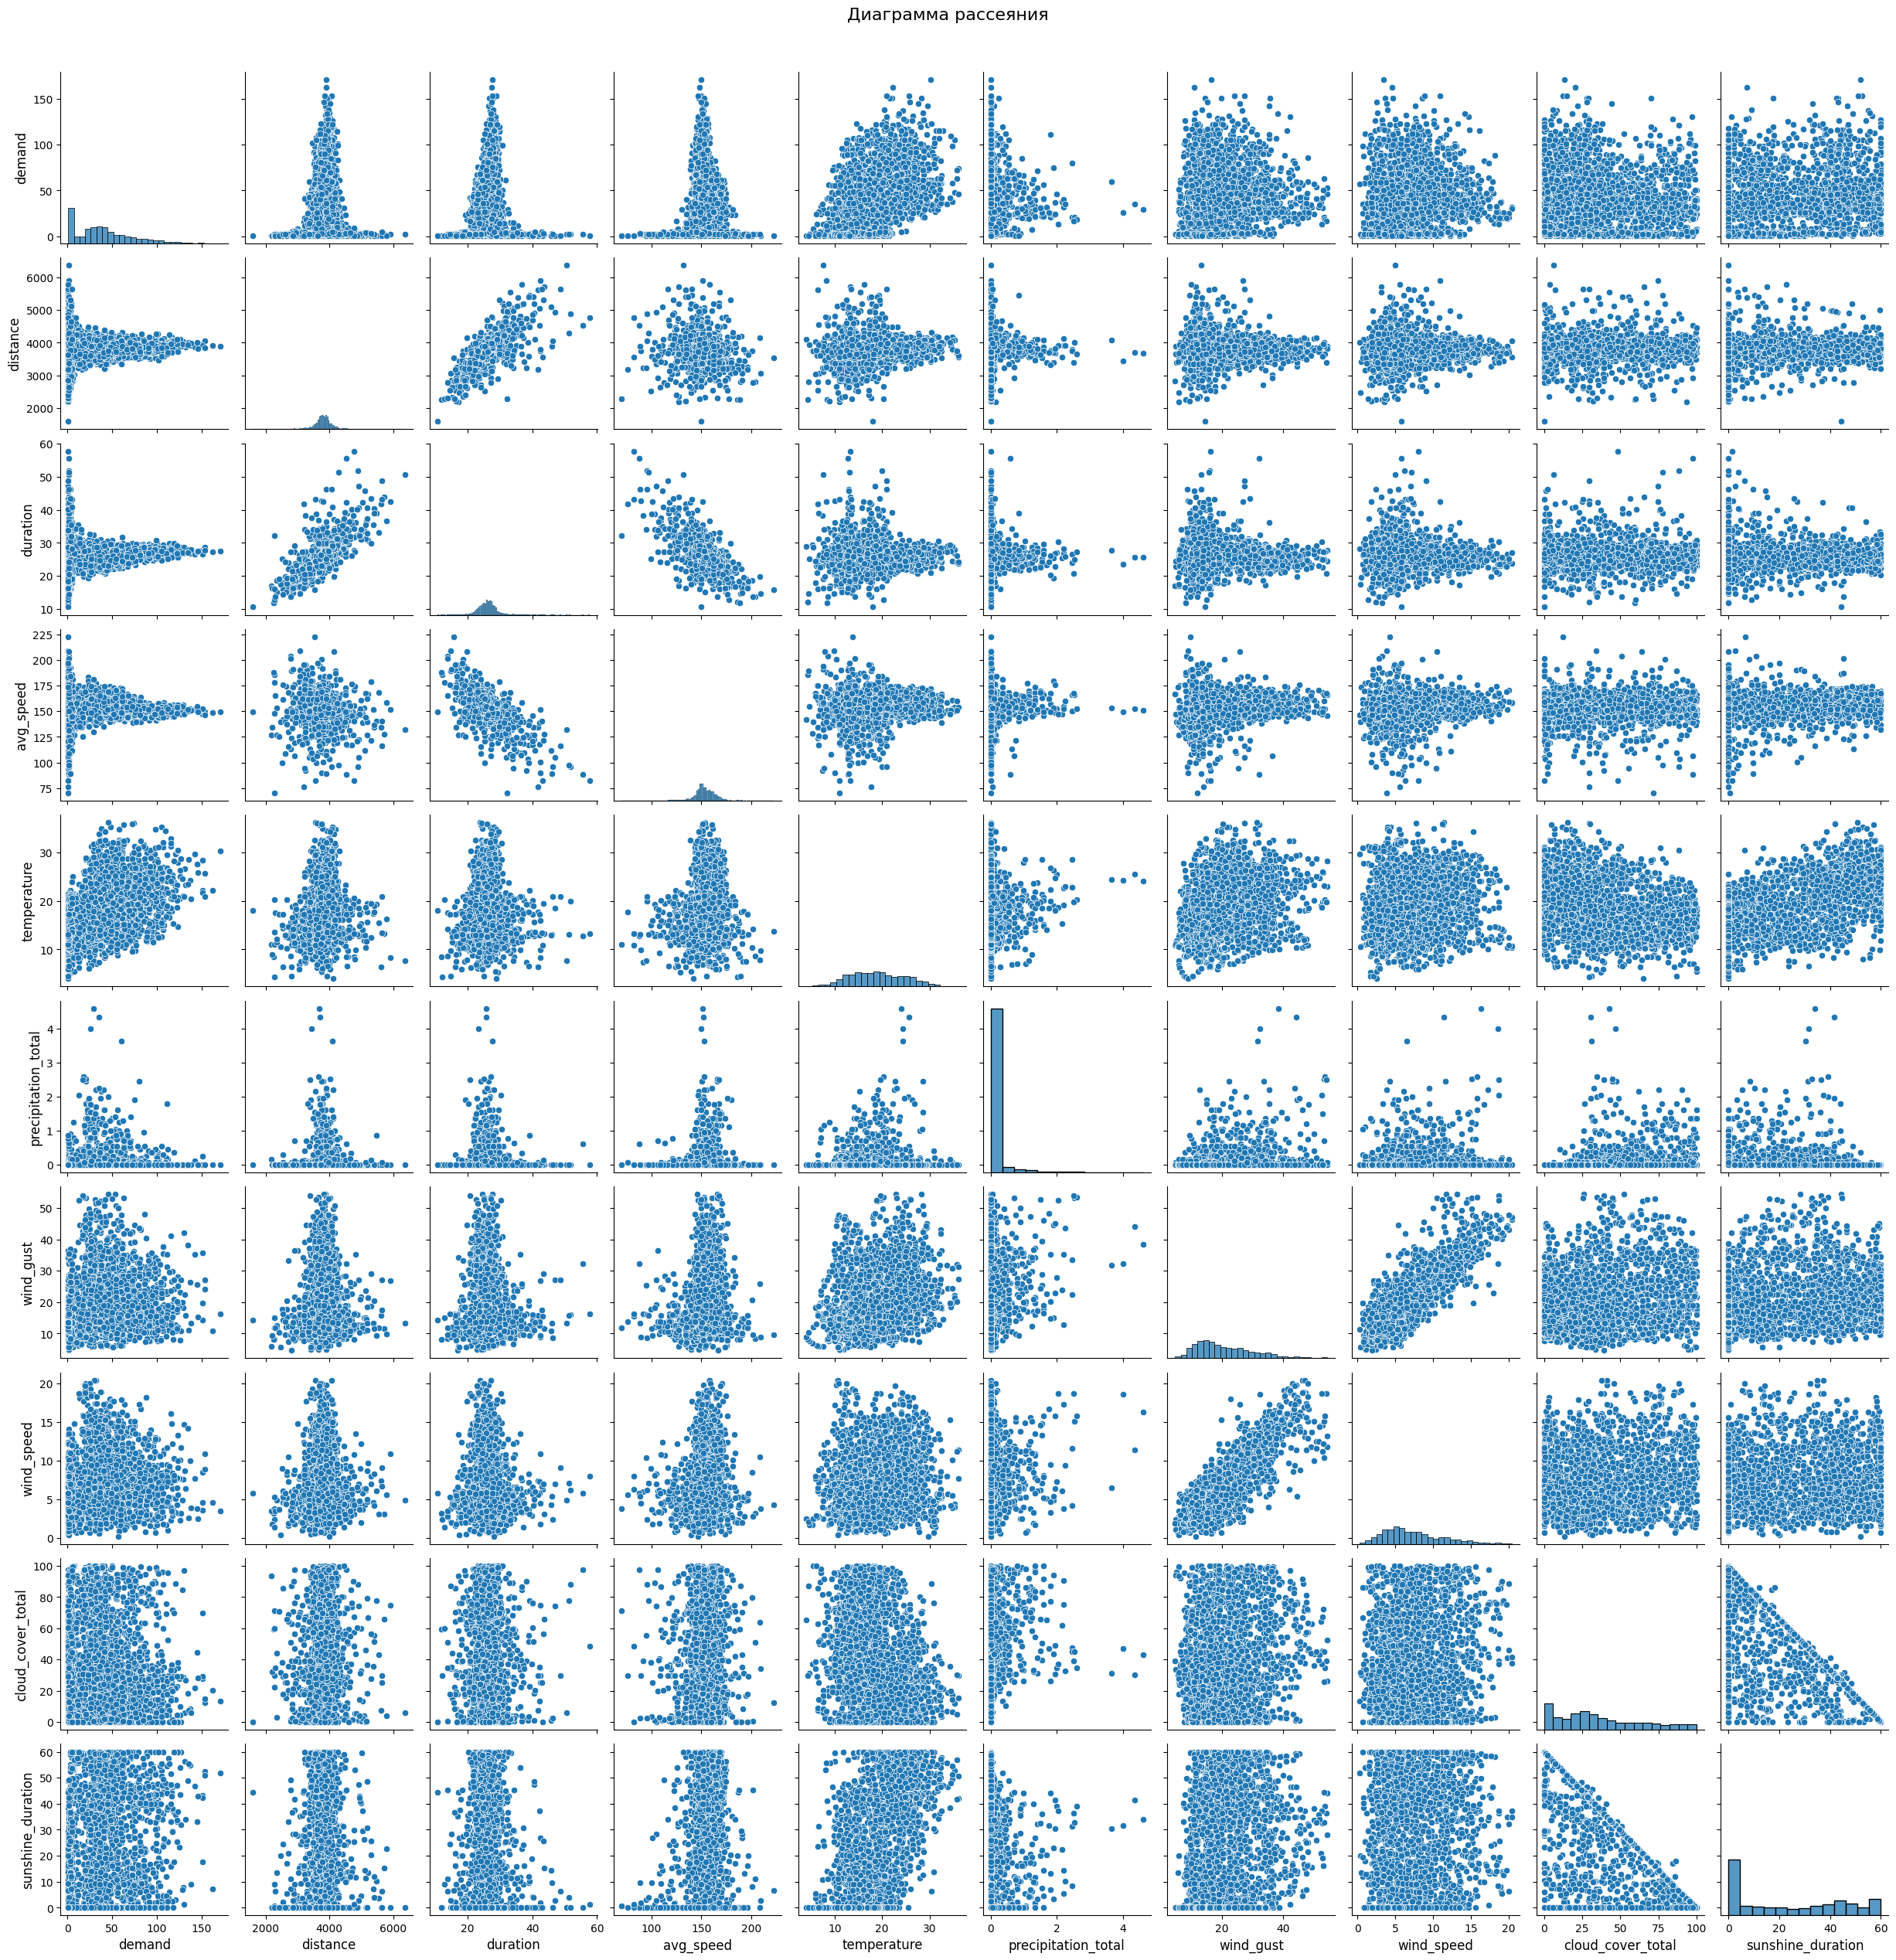

In [429]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
sns.pairplot(df_hourly_data[correlation_columns])
plt.suptitle("Диаграмма рассеяния", y=1.02, fontsize=16)
plt.show()

по графическому анализу корреляций небольшая зависимость прослеживается только с температрурой, нелинейных зависимостей не наблюдается

#### Анализ спроса с категариальными признаками

In [430]:
import scipy.stats as stats


def calculate_eta(df, quantitative_col, categorical_col):
    sst = ((df[quantitative_col] - df[quantitative_col].mean()) ** 2).sum()
    ssb = (
        df.groupby(categorical_col)[quantitative_col]
        .apply(lambda x: ((x.mean() - df[quantitative_col].mean()) ** 2) * len(x))
        .sum()
    )
    eta_squared = ssb / sst
    return eta_squared**0.5

In [431]:
eta_correlations = {}
for col in correlation_columns_cat:
    eta_value = calculate_eta(df_hourly_data, "demand", col)
    eta_correlations[col] = eta_value
eta_df = pd.DataFrame([eta_correlations], index=["demand"])
display(eta_df)

hour_of_day  day_of_week     month  is_weekend  promo_proportion  \
demand     0.844222     0.233791  0.098089    0.218342          0.024917   

        period_of_time  has_precipitation  
demand        0.783217           0.014459

Аналитический вывод: спрос сильно зависит от временных переменных и их классов

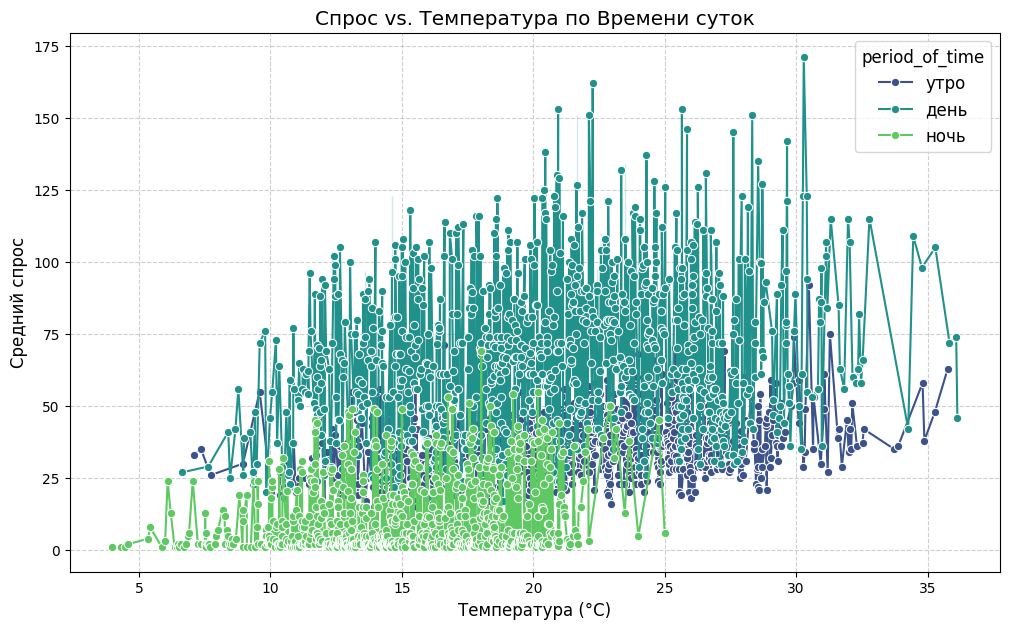

In [432]:
plt.figure(figsize=(12, 7))
sns.lineplot(
    data=df_hourly_data,
    x="temperature",
    y="demand",
    hue="period_of_time",
    marker="o",
    palette="viridis",
)
plt.title("Спрос vs. Температура по Времени суток")
plt.xlabel("Температура (°C)")
plt.ylabel("Средний спрос")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

По этому графику видно, что температура довольно сильно коррелирует с временем суток. Скорее всего физической связи между температурой и спросом нету, а иллюзия корреляции появляется из за корреляции температуры и времени суток.

Вывод: при постраинии предсказательных моделей для цены и динамического ценообразования очень важно учитывать время суток, день недели и некоторые факторы погоды, которые не так сильно коррелируют со временем, так как температруа имеет косвенную связь со спросом

## Проверка гипотез

Верно ли, что в дождливое время спрос на самокаты ниже?

Отличается ли средняя стоимость поездки по районам?

Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

Верно ли, что в выходные дни поездки более длительные?

Верно ли, что в будние дни поездки более скоростные?

In [433]:
df_hourly_data.head()

start_hour  demand     distance   duration   avg_speed  \
0 2023-04-22 09:00:00      20  3843.745228  26.528333  152.834451   
1 2023-04-22 10:00:00      42  3610.966916  24.956349  151.479698   
2 2023-04-22 11:00:00      29  3912.119219  26.064943  155.666465   
3 2023-04-22 12:00:00      46  3942.684162  27.094565  152.723147   
4 2023-04-22 13:00:00      47  3792.249365  24.993617  156.174165   

   temperature  precipitation_total  wind_gust  wind_speed  cloud_cover_total  \
0    15.040246                 0.00  21.780000    6.015271          79.500000   
1    16.655246                 0.05  32.580001    7.257886          91.000000   
2    17.605245                 0.05  35.640000    9.692592          58.100000   
3    18.350245                 0.00  25.080000   15.552307          52.066667   
4    18.460245                 0.00  22.860000   17.985765          67.000000   

   sunshine_duration  promo_proportion period_of_time  hour_of_day  \
0          11.818181             False           утро            9   
1           4.848484             False           утро           10   
2          24.787879             False           утро           11   
3          28.444443             False           утро           12   
4          19.393936             False           утро           13   

   day_of_week  month  is_weekend has_precipitation  
0            5      4           1               нет  
1            5      4           1              есть  
2            5      4           1              есть  
3            5      4           1               нет  
4            5      4           1               нет

### Верно ли, что в дождливое время спрос на самокаты ниже?

In [434]:
test_stapiro(df_hourly_data, "demand")

shapiro-Wilk Test Statistic для 'demand': 0.9356
shapiro-Wilk P-value для 'demand': 0.0000
Расспределение 'demand': Не нормальное распределение



Распределение не нормальное, используем критерий Манна-Уитни

H0: спрос не зависит от дождя

H1: спрос зависит от дождя

In [435]:
df_rain = df_hourly_data[df_hourly_data["has_precipitation"] == "есть"]
df_non_rain = df_hourly_data[df_hourly_data["has_precipitation"] == "нет"]
pv = float(st.mannwhitneyu(df_rain["demand"], df_non_rain["demand"])[1].round(4))
print("P-value:", pv)

P-value: 0.9771


P - уровень больше 0.05, а значит текущих данных не хватает, чтобы сделать вывод

### Отличается ли средняя стоимость поездки по районам?

In [436]:
rayon_mask = df_rides["start_district"] == df_rides["end_district"]
df_rayon = df_rides[rayon_mask]
test_stapiro(df_rayon, "cost")

shapiro-Wilk Test Statistic для 'cost': 0.9322
shapiro-Wilk P-value для 'cost': 0.0000
Расспределение 'cost': Не нормальное распределение



/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 17312.
  res = hypotest_fun_out(*samples, **kwds)


Распределение не нормальное, уровней больше двух, используем критерий Краскела-Уоллеса

H0: Цена одинаковая во всех районах

H1: Цена различается в районах

In [437]:
unique_rayons = df_rayon["start_district"].unique()
unique_rayons.sort()

cost_groups = [
    df_rayon[df_rayon["start_district"] == rayon]["cost"] for rayon in unique_rayons
]

_, p_value = st.kruskal(*cost_groups)

print("p-value", p_value)

p-value 0.5778932582579189


P - уровень больше 0.05, а значит текущих данных не хватает, чтобы сделать вывод

### Верно ли, что спрос на самокаты меняется в зависимости от дня недели?

In [438]:
test_stapiro(df_hourly_data, "demand")

shapiro-Wilk Test Statistic для 'demand': 0.9356
shapiro-Wilk P-value для 'demand': 0.0000
Расспределение 'demand': Не нормальное распределение



будем использовать непараметрический тест Краскела-Уоллиса (Kruskal-Wallis H test). Он является расширением теста Манна-Уитни для трех и более групп и не требует, чтобы данные имели нормальное распределение.

H0: Спрос одинаковый во все дни недели

H1: Спрос различается по дням недели

In [439]:
unique_days = df_hourly_data["day_of_week"].unique()
unique_days.sort()

demand_groups = [
    df_hourly_data[df_hourly_data["day_of_week"] == day]["demand"]
    for day in unique_days
]

_, p_value = st.kruskal(*demand_groups)

print("p-value", p_value)

p-value 1.4844434616228666e-15


p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. День недели ВЛИЯЕТ на спрос

### Верно ли, что в выходные дни поездки более длительные?

In [440]:
test_stapiro(df_hourly_data, "duration")

shapiro-Wilk Test Statistic для 'duration': 0.8680
shapiro-Wilk P-value для 'duration': 0.0000
Расспределение 'duration': Не нормальное распределение



распределение не нормальное, используем Манна-Уитни

H0: во все дни поездки одинаковы по длительности

H1: в выходные дни поездки отличаются по длительности

In [441]:
df_weekend = df_hourly_data[df_hourly_data["is_weekend"] == 1]
df_non_weekend = df_hourly_data[df_hourly_data["is_weekend"] == 0]

pv = st.mannwhitneyu(df_weekend["duration"], df_non_weekend["duration"])[1]
print("P-value:", pv)

P-value: 9.292707070135018e-75


p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. Выходные ВЛИЯЮТ на длительность поездки. Осталось узнать действительно ли они длительнее или, наоборот, короче

In [442]:
df_hourly_data.groupby("is_weekend")["duration"].median()

is_weekend
0    25.507435
1    27.507034
Name: duration, dtype: float64

Да, действительно в выходные поездки более длительные

### Верно ли, что в будние дни поездки более скоростные?

In [443]:
test_stapiro(df_hourly_data, "avg_speed")

shapiro-Wilk Test Statistic для 'avg_speed': 0.9036
shapiro-Wilk P-value для 'avg_speed': 0.0000
Расспределение 'avg_speed': Не нормальное распределение



распределение не нормальное, используем Манна-Уитни

H0: во все дни поездки одинаковы по скорости
H1: в будние дни поездки отличаются по скорости

In [444]:
pv = st.mannwhitneyu(df_weekend["avg_speed"], df_non_weekend["avg_speed"])[1]
print("P-value:", pv)

P-value: 2.1744736215877063e-33


p - уровень меньше 0.05, а значит мы отвергаем нулевую гипотезу. Будние дни ВЛИЯЮТ на скорость поездки. Осталось узнать действительно ли они скоростнее или, наоборот, медленнее

In [445]:
df_hourly_data.groupby("is_weekend")["avg_speed"].median()

is_weekend
0    154.636993
1    150.157815
Name: avg_speed, dtype: float64

Да, действительно в будние дни поездки скоростнее

In [446]:
total_rides = len(df_rides)

df_start_district_summary = df_rides.groupby('start_district').size().reset_index(name='count')
df_start_district_summary['proportion'] = (df_start_district_summary['count'] / total_rides) * 100

df_end_district_summary = df_rides.groupby('end_district').size().reset_index(name='count')
df_end_district_summary['proportion'] = (df_end_district_summary['count'] / total_rides) * 100

df_promo_summary = df_rides.groupby('promo').size().reset_index(name='count')
df_promo_summary['proportion'] = (df_promo_summary['count'] / total_rides) * 100

print("df_start_district_summary:")
print(df_start_district_summary.head())
print("\ndf_end_district_summary:")
print(df_end_district_summary.head())
print("\ndf_promo_summary:")
print(df_promo_summary.head())

df_start_district_summary:
    start_district  count  proportion
0         заречный   9333    9.586663
1        ленинский  15573   15.996261
2      октябрьский  13394   13.758038
3  северо-западный  15503   15.924359
4      центральный  25054   25.734947

df_end_district_summary:
      end_district  count  proportion
0         заречный   9093    9.340140
1        ленинский  15606   16.030158
2      октябрьский  13650   14.020996
3  северо-западный  15714   16.141093
4      центральный  24455   25.119666

df_promo_summary:
   promo  count  proportion
0  False  95443   98.037061
1   True   1911    1.962939


## Создание дата фреймов для визуализации

In [447]:
df_start_district_summary_dashboard = df_start_district_summary.copy()
df_end_district_summary_dashboard = df_end_district_summary.copy()
df_promo_summary_dashboard = df_promo_summary.copy()

print("df_start_district_summary_dashboard created.")
print("df_end_district_summary_dashboard created.")
print("df_promo_summary_dashboard created.")

df_start_district_summary_dashboard created.
df_end_district_summary_dashboard created.
df_promo_summary_dashboard created.


In [448]:
df_promo_comparison_dashboard = pd.DataFrame({
    'Metric': [
        'Total Profit',
        'Number of Rides',
        'Average Distance',
        'Average Duration',
        'Average Profit per Ride'
    ],
    'Promotion Period (Понедельник 06:00-10:00)': [
        profit_in_monday,
        rides_promotion,
        avg_distance_promotion,
        avg_duration_promotion,
        avg_profit_promotion
    ],
    'Non-Promotion Period (Вторник 06:00-10:00)': [
        profit_in_tuesday,
        rides_not_promotion,
        avg_distance_not_promotion,
        avg_duration_not_promotion,
        avg_profit_not_promotion
    ]
})

print("df_promo_comparison_dashboard created.")
print(df_promo_comparison_dashboard.head())


df_promo_comparison_dashboard created.
                    Metric  Promotion Period (Понедельник 06:00-10:00)  \
0             Total Profit                               287588.111768   
1          Number of Rides                                 2675.000000   
2         Average Distance                                 3782.606595   
3         Average Duration                                   24.735338   
4  Average Profit per Ride                                  107.509574   

   Non-Promotion Period (Вторник 06:00-10:00)  
0                               276373.891309  
1                                 2152.000000  
2                                 3798.039707  
3                                   24.606632  
4                                  128.426529  


In [449]:
df_location_traffic_profit_dashboard = df_rides_hourly_traffic_final[['total_count_rides']].reset_index()
df_location_traffic_profit_dashboard = pd.merge(
    df_location_traffic_profit_dashboard,
    df_profit_per_location,
    left_on='start_location',
    right_on='start_location',
    how='left'
)
df_location_traffic_profit_dashboard = pd.merge(
    df_location_traffic_profit_dashboard,
    df_location_district,
    left_on='start_location',
    right_on='start_location',
    how='left'
)
print("df_location_traffic_profit_dashboard created.")
print(df_location_traffic_profit_dashboard.head())

df_location_traffic_profit_dashboard created.
  start_location  total_count_rides   total_profit   start_district
0      береговая              874.0  149160.196964      центральный
1      березовая             1227.0  225614.160137  северо-западный
2      буденного             2185.0  373358.604256      октябрьский
3       вишневая              834.0  152964.302092    юго-восточный
4     вокзальная              826.0  149256.024860    юго-восточный


In [450]:
df_top_3_locations_dashboard = df_location_traffic_profit_dashboard.sort_values(by='total_count_rides', ascending=False).head(3)
print("df_top_3_locations_dashboard created.")
print(df_top_3_locations_dashboard)

df_top_3_locations_dashboard created.
   start_location  total_count_rides   total_profit start_district
35        луговая             2293.0  397106.406852    октябрьский
34     ломоносова             2292.0  395544.985202    октябрьский
36        майская             2235.0  378961.901259    октябрьский


In [451]:
df_bottom_10_locations_dashboard = top_10_of_tails_locations_with_profit.copy()
print("df_bottom_10_locations_dashboard created.")
print(df_bottom_10_locations_dashboard.head())

df_bottom_10_locations_dashboard created.
  start_location start_district  total_count_rides   total_profit
0           мира    центральный              779.0  134055.737359
1     набережная    центральный              793.0  136331.035109
2    энтузиастов    центральный              794.0  138424.140615
3      сиреневая  юго-восточный              795.0  146688.648258
4         дружбы    центральный              800.0  140926.032550


In [452]:
df_popular_destinations_dashboard = popular_travel_destinations.copy()
print("df_popular_destinations_dashboard created.")
print(df_popular_destinations_dashboard.head())

df_popular_destinations_dashboard created.
                 destinations  ride_count
184    буденного -> буденного          68
3256    луговая -> спортивная          67
3347    майская -> спортивная          61
6586    спортивная -> майская          60
489   восточная -> ломоносова          59


In [453]:
df_daily_net_change_summary_dashboard = daily_net_change.reset_index()
df_daily_net_change_summary_dashboard.columns = ['location', 'avg_net_change']
print("df_daily_net_change_summary_dashboard created.")
print(df_daily_net_change_summary_dashboard.head())

df_daily_net_change_summary_dashboard created.
     location  avg_net_change
0  спортивная        1.186275
1   буденного        0.931373
2   восточная        0.872549
3      ленина        0.784314
4   матросова        0.764706


In [454]:
df_optimal_scooters_by_district_dashboard = optimal_scooters_by_district.reset_index()
df_optimal_scooters_by_district_dashboard.columns = ['district', 'optimal_count']
print("df_optimal_scooters_by_district_dashboard created.")
print(df_optimal_scooters_by_district_dashboard.head())

df_optimal_scooters_by_district_dashboard created.
          district  optimal_count
0      центральный            247
1    юго-восточный            181
2        ленинский            154
3  северо-западный            153
4      октябрьский            134


In [455]:
df_end_of_day_net_change_summary_dashboard = end_of_day_net_change.reset_index()
df_end_of_day_net_change_summary_dashboard.columns = ['location', 'net_change_at_23h']
print("df_end_of_day_net_change_summary_dashboard created.")
print(df_end_of_day_net_change_summary_dashboard.head())

df_end_of_day_net_change_summary_dashboard created.
        location  net_change_at_23h
0    октябрьская                 36
1        красная                 31
2      восточная                 30
3  комсомольская                 29
4        садовая                 27


In [456]:
df_optimal_scooters_dashboard = optimal_scooters_df.copy()
print("df_optimal_scooters_dashboard created.")
print(df_optimal_scooters_dashboard.head())

df_optimal_scooters_dashboard created.
     location  optimal_scooters         district
0   береговая                 9      центральный
1   березовая                12  северо-западный
2   буденного                22      октябрьский
3    вишневая                 8    юго-восточный
4  вокзальная                 8    юго-восточный


In [457]:
numerical_correlations = correlation_matrix['demand'].drop('demand').reset_index()
numerical_correlations.columns = ['Feature', 'Value']
numerical_correlations['Correlation Type'] = 'Spearman'

categorical_correlations = eta_df.T.reset_index()
categorical_correlations.columns = ['Feature', 'Value']
categorical_correlations['Correlation Type'] = 'Eta-squared'

df_demand_correlations_dashboard = pd.concat([numerical_correlations, categorical_correlations], ignore_index=True)

print("df_demand_correlations_dashboard created.")
print(df_demand_correlations_dashboard.head())
print(df_demand_correlations_dashboard.tail())

df_demand_correlations_dashboard created.
               Feature     Value Correlation Type
0             distance  0.112506         Spearman
1             duration  0.109288         Spearman
2            avg_speed -0.016593         Spearman
3          temperature  0.464972         Spearman
4  precipitation_total  0.004220         Spearman
              Feature     Value Correlation Type
11              month  0.098089      Eta-squared
12         is_weekend  0.218342      Eta-squared
13   promo_proportion  0.024917      Eta-squared
14     period_of_time  0.783217      Eta-squared
15  has_precipitation  0.014459      Eta-squared


In [458]:
hypothesis_data = [
    {
        "Hypothesis": "В дождливое время спрос на самокаты ниже?",
        "P-value": 0.9771,
        "Conclusion": "Не отвергаем H0"
    },
    {
        "Hypothesis": "Отличается ли средняя стоимость поездки по районам?",
        "P-value": 0.5779,
        "Conclusion": "Не отвергаем H0"
    },
    {
        "Hypothesis": "Спрос на самокаты меняется в зависимости от дня недели?",
        "P-value": 1.4844e-15,
        "Conclusion": "Отвергаем H0"
    },
    {
        "Hypothesis": "В выходные дни поездки более длительные?",
        "P-value": 9.2927e-75,
        "Conclusion": "Отвергаем H0"
    },
    {
        "Hypothesis": "В будние дни поездки более скоростные?",
        "P-value": 2.1745e-33,
        "Conclusion": "Отвергаем H0"
    }
]

df_hypothesis_results_dashboard = pd.DataFrame(hypothesis_data)

print("df_hypothesis_results_dashboard created.")
print(df_hypothesis_results_dashboard)

df_hypothesis_results_dashboard created.
                                          Hypothesis       P-value  \
0          В дождливое время спрос на самокаты ниже?  9.771000e-01   
1  Отличается ли средняя стоимость поездки по рай...  5.779000e-01   
2  Спрос на самокаты меняется в зависимости от дн...  1.484400e-15   
3           В выходные дни поездки более длительные?  9.292700e-75   
4             В будние дни поездки более скоростные?  2.174500e-33   

        Conclusion  
0  Не отвергаем H0  
1  Не отвергаем H0  
2     Отвергаем H0  
3     Отвергаем H0  
4     Отвергаем H0  


In [459]:
df_weekly_profit = df_rides.groupby(df_rides['start_date'].dt.isocalendar().week)['cost'].sum().reset_index()
df_weekly_profit.columns = ['week', 'weekly_profit']
df_weekly_profit['cumulative_profit'] = df_weekly_profit['weekly_profit'].cumsum()
df_weekly_profit_dashboard = df_weekly_profit.copy()

df_monthly_profit = df_rides.groupby(df_rides['start_date'].dt.month)['cost'].sum().reset_index()
df_monthly_profit.columns = ['month', 'monthly_profit']
df_monthly_profit['cumulative_profit'] = df_monthly_profit['monthly_profit'].cumsum()
df_monthly_profit_dashboard = df_monthly_profit.copy()

print("\ndf_weekly_profit_dashboard created:")
print(df_weekly_profit_dashboard.head())
print("\ndf_monthly_profit_dashboard created:")
print(df_monthly_profit_dashboard.head())


df_weekly_profit_dashboard created:
   week  weekly_profit  cumulative_profit
0    16   3.953445e+05       3.953445e+05
1    17   1.028117e+06       1.423461e+06
2    18   1.115326e+06       2.538788e+06
3    19   1.024112e+06       3.562900e+06
4    20   1.086034e+06       4.648934e+06

df_monthly_profit_dashboard created:
   month  monthly_profit  cumulative_profit
0      4    1.423461e+06       1.423461e+06
1      5    4.818831e+06       6.242292e+06
2      6    5.332984e+06       1.157528e+07
3      7    5.806598e+06       1.738187e+07


In [460]:
df_daily_profit = df_rides.groupby(df_rides['start_date'].dt.date)['cost'].sum().reset_index()
df_daily_profit.columns = ['date', 'daily_profit']
df_daily_profit['cumulative_profit'] = df_daily_profit['daily_profit'].cumsum()
df_daily_profit_dashboard = df_daily_profit.copy()

print("\ndf_daily_profit_dashboard created:")
print(df_daily_profit_dashboard.head())


df_daily_profit_dashboard created:
         date   daily_profit  cumulative_profit
0  2023-04-22  201455.663148      201455.663148
1  2023-04-23  193888.883420      395344.546568
2  2023-04-24  104723.910204      500068.456772
3  2023-04-25   98789.662218      598858.118990
4  2023-04-26  119595.930723      718454.049713


In [461]:
df_rides['date'] = df_rides['start_date'].dt.date

df_daily_profit_per_location = df_rides.groupby(['start_location', 'date'])['cost'].sum().reset_index()
df_daily_profit_per_location.rename(columns={'cost': 'daily_profit'}, inplace=True)

df_daily_profit_per_location = df_daily_profit_per_location.sort_values(by=['start_location', 'date'])
df_daily_profit_per_location['cumulative_profit'] = df_daily_profit_per_location.groupby('start_location')['daily_profit'].cumsum()

df_location_daily_profit_dashboard = pd.merge(
    df_daily_profit_per_location,
    df_location_district,
    on='start_location',
    how='left'
)

print("df_location_daily_profit_dashboard created.")
print(df_location_daily_profit_dashboard.head())

df_location_daily_profit_dashboard created.
  start_location        date  daily_profit  cumulative_profit start_district
0      береговая  2023-04-22    964.283333         964.283333    центральный
1      береговая  2023-04-23   1000.100000        1964.383333    центральный
2      береговая  2023-04-24    988.900000        2953.283333    центральный
3      береговая  2023-04-25    701.083333        3654.366667    центральный
4      береговая  2023-04-26    863.400000        4517.766667    центральный


In [462]:
df_location_daily_profit_dashboard.to_csv('df_location_daily_profit_dashboard.csv', index=False, encoding='utf-8')